In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Image Rotation

# Generate a list of rotated images

In [3]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt

# angles = for k in range(15, 181, 15)
# angles = [15,30,45,60,75,90,105,120,135,150,165,180]
angle = 30

def rotate_images(images, angle):
    rotated_images = []
    for img in images:
        rotated_image = ndimage.rotate(img, angle, reshape=False)
        # rotated_image = ndimage.rotate(img, angle, reshape=True)
        rotated_images.append(rotated_image)
    return rotated_images

train_rotated_images = rotate_images(train_dataset.data, angle)
test_rotated_images = rotate_images(test_dataset.data, angle)

train_rotated_images = np.array(train_rotated_images)
test_rotated_images = np.array(test_rotated_images)
print("Train rotated images shape")
print(train_rotated_images.shape)

print("Test rotated images shape")
print(test_rotated_images.shape)



Train rotated images shape
(50000, 32, 32, 3)
Test rotated images shape
(10000, 32, 32, 3)


# Visualizing generated rotated images

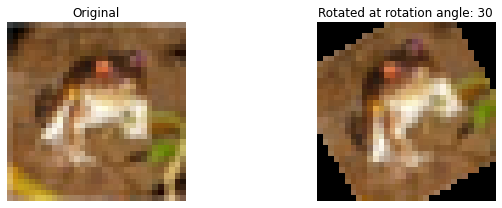

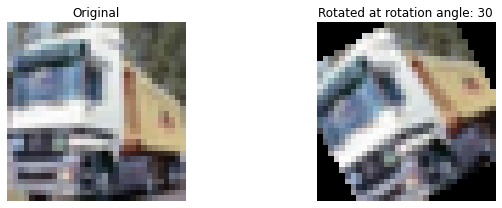

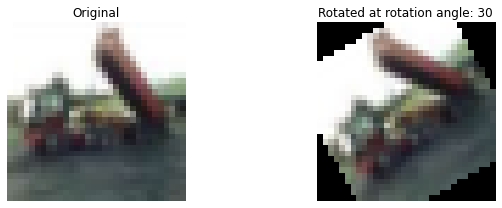

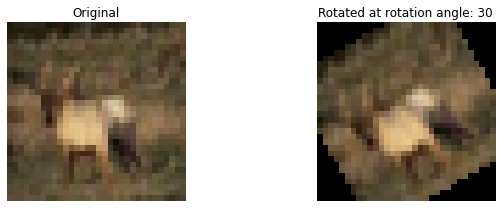

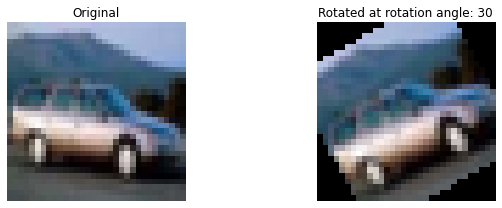

In [4]:
i=0
for rotated_image in train_rotated_images:
    fig = plt.figure(figsize=(10, 3))
    ax1,ax2 = fig.subplots(1,2)
    ax1.imshow(train_dataset.data[i], cmap='gray')
    ax1.set_axis_off()
    ax1.set_title("Original")
    ax2.imshow(rotated_image, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title("Rotated at rotation angle: "+str(angle))
    fig.set_tight_layout(True)
    plt.show()
    i +=1
    
    if i==5:
        break
    

# Combining original and rotated images

In [5]:
original_image_labels = np.zeros(len(train_dataset.data))
rotated_image_labels = np.ones(len(train_rotated_images))

test_original_image_labels = np.zeros(len(test_dataset.data))
test_rotated_image_labels = np.ones(len(test_rotated_images))

train_original_and_rotated_images = np.concatenate((train_dataset.data, train_rotated_images), axis=0)
train_rotation_labels = np.concatenate((original_image_labels, rotated_image_labels), axis=None)
train_image_labels = np.concatenate((train_dataset.targets, train_dataset.targets), axis=None)

test_original_and_rotated_images = np.concatenate((test_dataset.data, test_rotated_images), axis=0)
test_rotation_labels = np.concatenate((test_original_image_labels, test_rotated_image_labels), axis=None)


print("Combined rotated and original images shape")
print(train_original_and_rotated_images.shape)


Combined rotated and original images shape
(100000, 32, 32, 3)


# Extract image features

In [6]:
from image_feature_extractor import Img2Vec

img2vec = Img2Vec()

Z = img2vec.get_vec(train_original_and_rotated_images)

Z_test = img2vec.get_vec(test_original_and_rotated_images)

Z_test_original = img2vec.get_vec(test_dataset.data)

Z_test_rotated = img2vec.get_vec(test_rotated_images)

# vec.shape
print("Shape of extracted features for combined rotated and original images")
print(Z.shape)

print("Shape of extracted features for original test images")
print(Z_test_original.shape)

print("Shape of extracted features for rotated test images")
print(Z_test_rotated.shape)


Shape of extracted features for combined rotated and original images
(100000, 512)
Shape of extracted features for original test images
(10000, 512)
Shape of extracted features for rotated test images
(10000, 512)


# Obtaining rotation prediction coefficients

In [7]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, train_rotation_labels)

rotation_coefficients = lr_model.coef_.reshape(-1,1)
rotation_coefficients = rotation_coefficients / np.linalg.norm(rotation_coefficients)

# print("Printing some of rotation coefficients")
# print(rotation_coefficients[:5,:])
# print()
print("Rotation coefficients shape")
print(rotation_coefficients.shape)

print('Rotation prediction accuracy on training data: ', lr_model.score(Z, train_rotation_labels))

print('Rotation prediction accuracy on test data-rotated and original combined: ', lr_model.score(Z_test, test_rotation_labels))

    


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Rotation coefficients shape
(512, 1)
Rotation prediction accuracy on training data:  0.99533
Rotation prediction accuracy on test data-rotaed and original combined:  0.99405


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

In [8]:
# Trained on original extracted image features Z, tested on rotated extracted image features Z
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


targets_train = np.array(test_dataset.targets)
targets_test = np.array(test_dataset.targets)


logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z_test_original, targets_train)

print('LR Accuracy within training data - Z original features: ',logistic_regression_model.score(Z_test_original, targets_train))
print('LR Accuracy on test data - Z rotated features: ', logistic_regression_model.score(Z_test_rotated, targets_test))



LR Accuracy within training data - Z original features:  0.7486
LR Accuracy on test data - Z rotated features:  0.3359


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Find L, get F features, plot histograms and perform predictions





Results for lamda  100000

Printing eigenvalues
(512,)
[-4.12240363e-10  1.13535706e+02  9.73683863e+02  1.38666822e+03
  1.52204443e+03  1.56044557e+03  1.58281380e+03  1.69466997e+03
  1.77667004e+03  1.92810785e+03  1.98910112e+03  2.03288317e+03
  2.08005686e+03  2.14189408e+03  2.30503908e+03  2.41434932e+03
  2.52329954e+03  2.58915521e+03  2.63139412e+03  2.78849582e+03
  2.83376100e+03  2.90648689e+03  2.92625112e+03  2.97177328e+03
  3.04886463e+03  3.10657572e+03  3.15223871e+03  3.16507261e+03
  3.19023815e+03  3.23442139e+03  3.27227669e+03  3.34196811e+03
  3.39379406e+03  3.39912444e+03  3.43919621e+03  3.52456912e+03
  3.55182257e+03  3.57429646e+03  3.61683241e+03  3.66688190e+03
  3.70501870e+03  3.71681285e+03  3.74229755e+03  3.78975937e+03
  3.81152996e+03  3.85006988e+03  3.89677291e+03  3.92703932e+03
  4.00505353e+03  4.00681802e+03  4.08516361e+03  4.09400007e+03
  4.16021862e+03  4.20338716e+03  4.23019451e+03  4.27505387e+03
  4.29793391e+03  4.32171759e+0

(512, 512)

array([[ 5.30513660e-02, -1.97902367e-03,  9.83056237e-05, ...,
        -2.77533212e-02,  2.60267394e-02,  5.11240667e-02],
       [ 9.86060432e-03, -5.11521598e-04,  7.22304709e-04, ...,
        -2.29537282e-02,  2.21968311e-02,  1.03464822e-01],
       [-2.56525487e-02,  9.65771334e-05, -2.79618422e-03, ...,
         9.85765729e-02,  1.11260930e-01,  1.08461597e-01],
       ...,
       [ 7.37840130e-03, -2.03249583e-04, -1.25559642e-04, ...,
        -1.83071559e-02, -1.15387157e-02,  3.09492315e-02],
       [-4.95922806e-02,  5.44258030e-04, -1.67662157e-03, ...,
        -2.94748432e-02,  5.29093886e-02,  3.66673313e-02],
       [ 1.84949439e-02, -1.39437172e-02,  5.52499776e-03, ...,
         5.47117911e-03, -2.29337204e-02,  9.02485916e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[   0.          113.53570607  973.68386327 1386.66822494 1522.04443366
 1560.44557347 1582.81379903 1694.66997431 1776.67004306 1928.1078463
 1989.10111797 2032.88317456 2080.05685679 2141.89407933 2305.03907573
 2414.3493173  2523.29954456 2589.15520923 2631.39412036 2788.49582336
 2833.76100163 2906.48688592 2926.25112455 2971.7732809  3048.86462901
 3106.57571661 3152.23871337 3165.07261155 3190.23815428 3234.42138879
 3272.27668614 3341.96810881 3393.79406247 3399.12444    3439.19620879
 3524.56911757 3551.82257178 3574.29646185 3616.832413   3666.88190238
 3705.01869899 3716.81284926 3742.29754746 3789.75936764 3811.52996112
 3850.0698786  3896.77291496 3927.03931814 4005.05353193 4006.81802115
 4085.16361128]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 113.53570607  973.68386327 1386.66822494 1522.04443366 1560.44557347
 1582.81379903 1694.66997431 1776.67004306 1928.1078463  1989.10111797
 2

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,3.014026,0.001205,0.011345,0.043879,0.002769,0.062673,0.213526,0.060213,0.025372,0.136942,...,0.027295,0.343899,0.091791,0.242151,0.273424,0.344556,0.059555,0.027005,0.026007,0.095433
1,2.435494,0.015381,0.807916,0.171112,0.043540,0.228113,0.184805,0.197458,0.198982,0.192582,...,0.237361,0.200029,0.680426,0.421342,0.112719,0.110305,0.117557,0.092522,0.106589,0.205964
2,3.148465,0.013777,0.004360,0.101988,0.284126,0.007379,0.009958,0.257834,0.011024,0.174276,...,0.077112,0.410032,0.400704,0.166355,0.000396,0.172809,0.069955,0.100725,0.108463,0.121805
3,3.554349,0.002414,0.027814,0.078695,0.079132,0.065876,0.058335,0.287415,0.019425,0.017088,...,0.291357,0.353723,0.055477,0.160020,0.078332,0.134622,0.171639,0.032934,0.022746,0.164713
4,2.496241,0.020911,0.047478,0.142521,0.024462,0.018559,0.079109,0.227914,0.119280,0.010967,...,0.074598,0.019221,0.006387,0.016534,0.014790,0.041075,0.218660,0.495210,0.419196,0.216427


Histogram for F Test feature  0


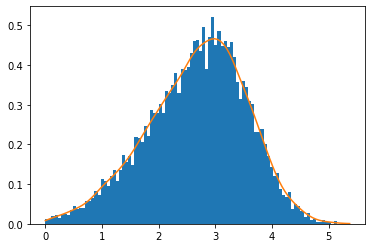

Histogram for F Test feature  1


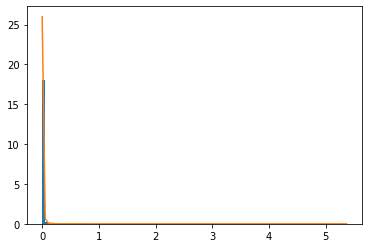

Histogram for F Test feature  2


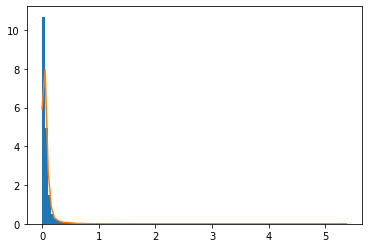

Histogram for F Test feature  3


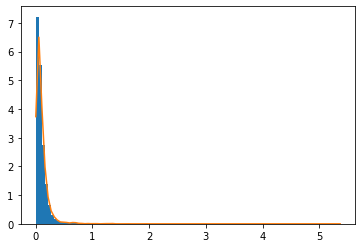

Histogram for F Test feature  4


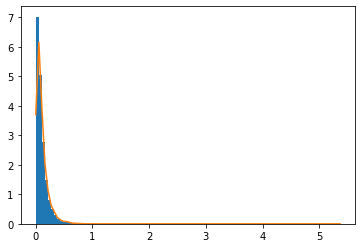

Histogram for F Test feature  5


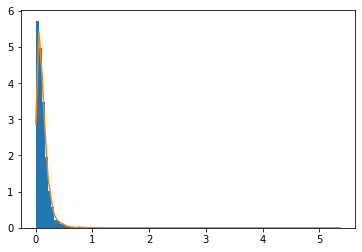

Histogram for F Test feature  6


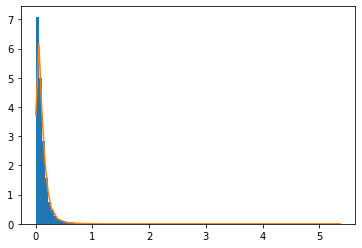

Histogram for F Test feature  7


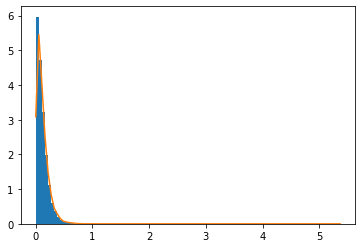

Histogram for F Test feature  8


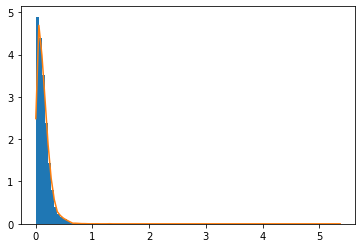

Histogram for F Test feature  9


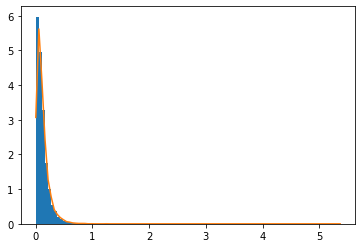

Histogram for F Test feature  10


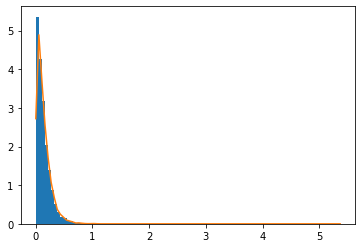

Histogram for F Test feature  11


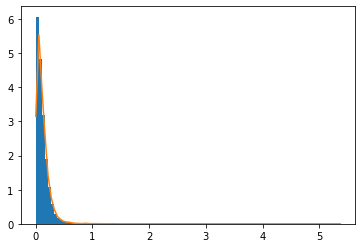

Histogram for F Test feature  12


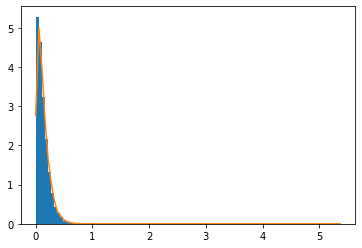

Histogram for F Test feature  13


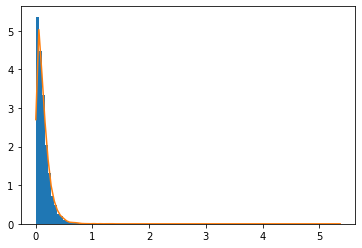

Histogram for F Test feature  14


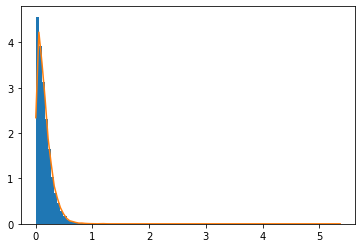

Histogram for F Test feature  15


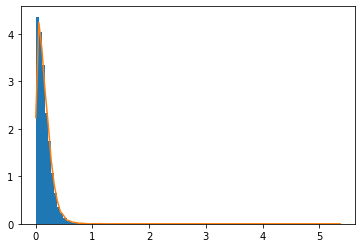

Histogram for F Test feature  16


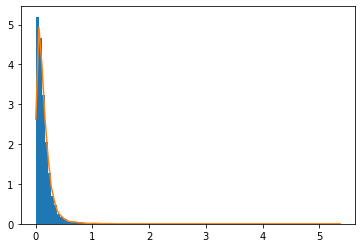

Histogram for F Test feature  17


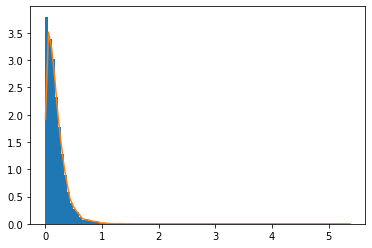

Histogram for F Test feature  18


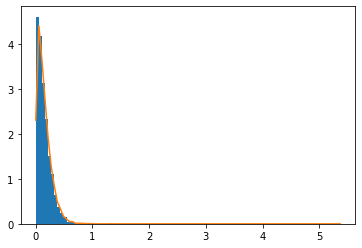

Histogram for F Test feature  19


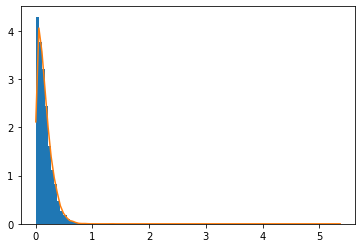

Histogram for F Test feature  20


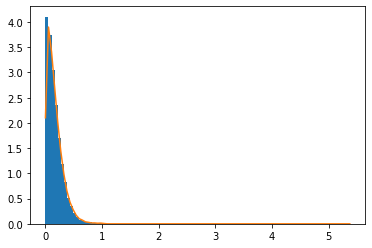

Histogram for F Test feature  21


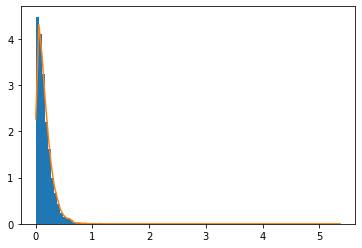

Histogram for F Test feature  22


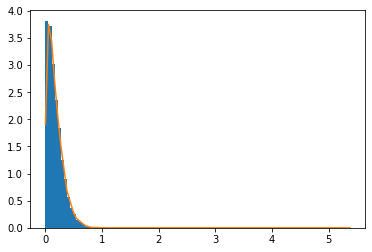

Histogram for F Test feature  23


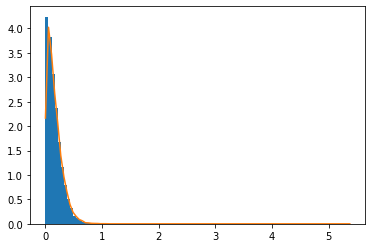

Histogram for F Test feature  24


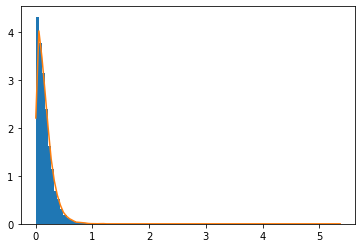

Histogram for F Test feature  25


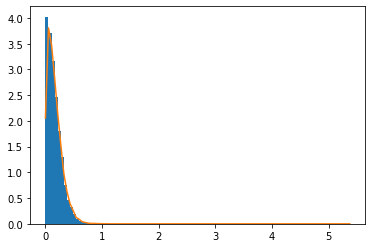

Histogram for F Test feature  26


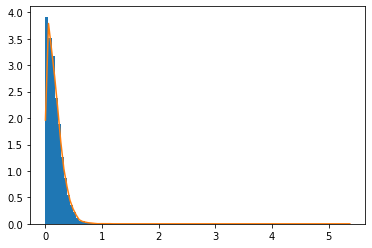

Histogram for F Test feature  27


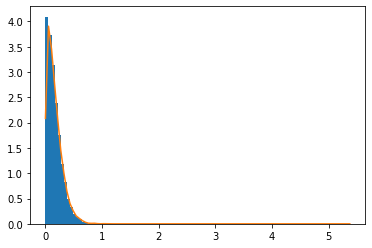

Histogram for F Test feature  28


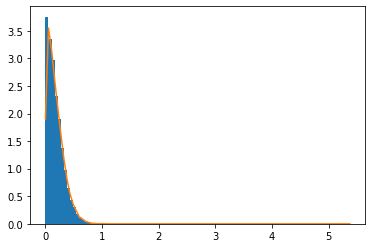

Histogram for F Test feature  29


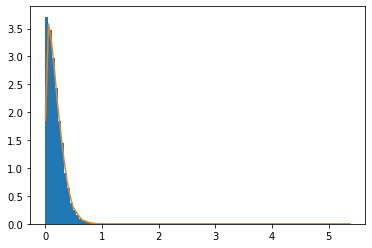

Histogram for F Test feature  30


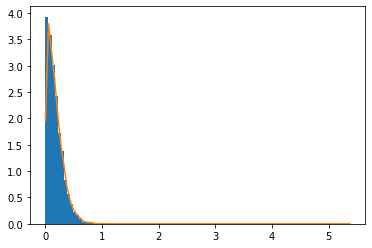

Histogram for F Test feature  31


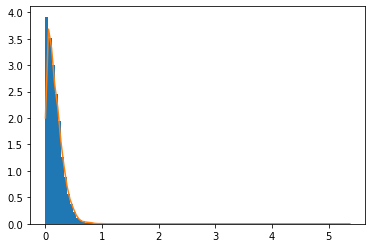

Histogram for F Test feature  32


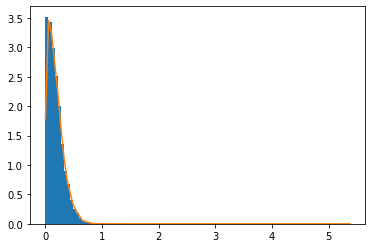

Histogram for F Test feature  33


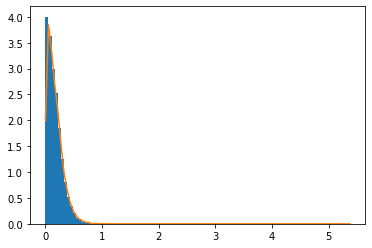

Histogram for F Test feature  34


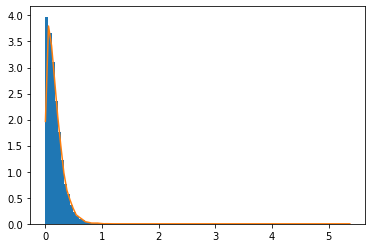

Histogram for F Test feature  35


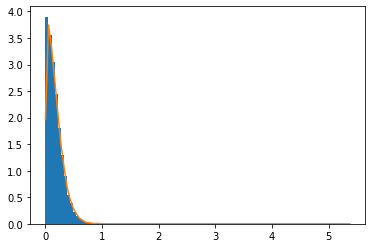

Histogram for F Test feature  36


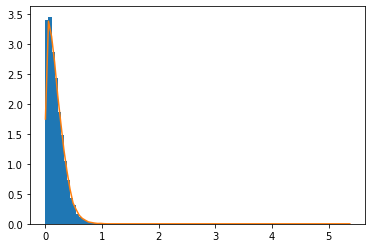

Histogram for F Test feature  37


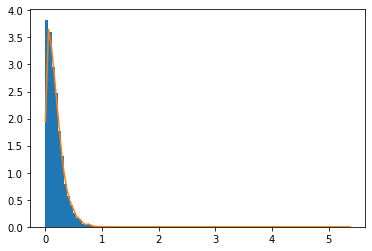

Histogram for F Test feature  38


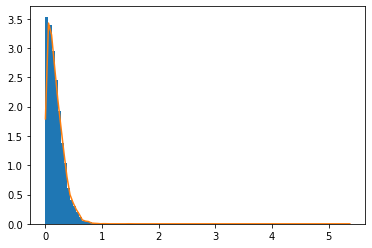

Histogram for F Test feature  39


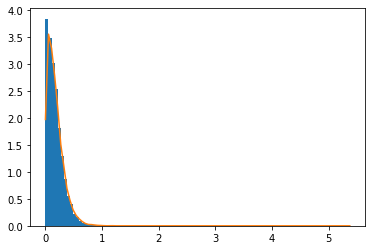

Histogram for F Test feature  40


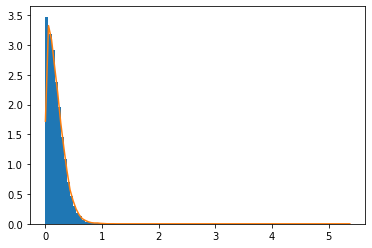

Histogram for F Test feature  41


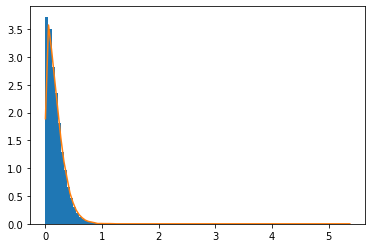

Histogram for F Test feature  42


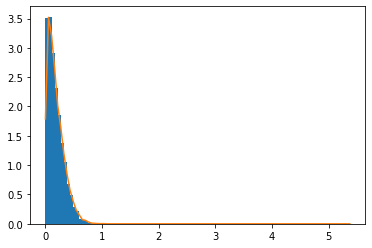

Histogram for F Test feature  43


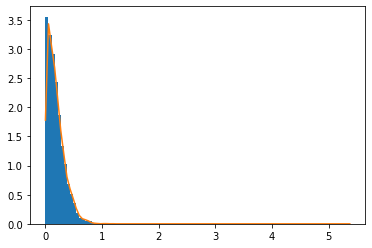

Histogram for F Test feature  44


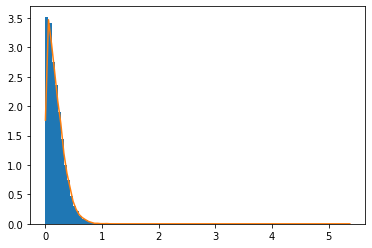

Histogram for F Test feature  45


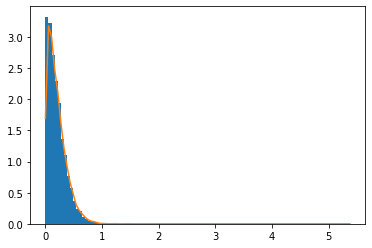

Histogram for F Test feature  46


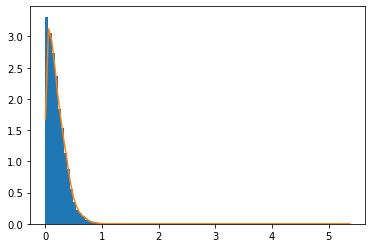

Histogram for F Test feature  47


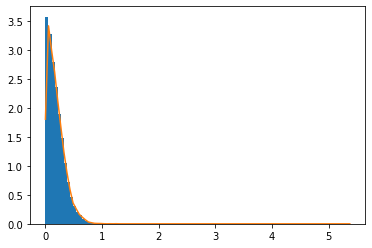

Histogram for F Test feature  48


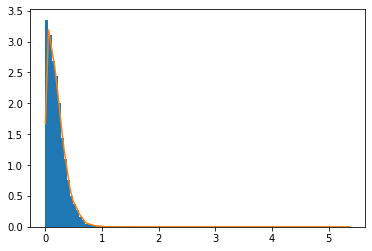

Histogram for F Test feature  49


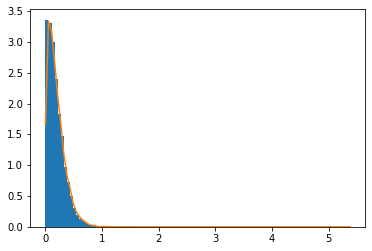

Histogram for F Test feature  50


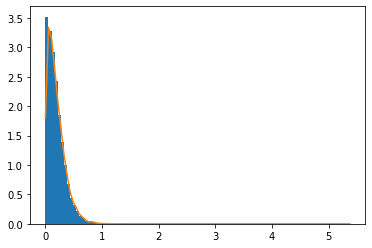

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.3793
LR Accuracy on test data - All features:  0.168
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not rotated:  0.3638
Logistic Regression Accuracy on test data - rotated:  0.178
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not rotated:  0.3771
Logistic Regression Accuracy on test data - rotated:  0.1676
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3758
Logistic Regression Accuracy on test data - rotated:  0.1678
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3779
Logistic Regression Accuracy on test data - rotated:  0.1675
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.379
Logistic Regression Accuracy on test data - rotated:  0.1674
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3758
Logistic Regression Accuracy on test data - rotated:  0.1684
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3761
Logistic Regression Accuracy on test data - rotated:  0.1666
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3774
Logistic Regression Accuracy on test data - rotated:  0.1671
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3756
Logistic Regression Accuracy on test data - rotated:  0.1679
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.376
Logistic Regression Accuracy on test data - rotated:  0.1688
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3769
Logistic Regression Accuracy on test data - rotated:  0.1693
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3734
Logistic Regression Accuracy on test data - rotated:  0.1662
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3769
Logistic Regression Accuracy on test data - rotated:  0.1686
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3759
Logistic Regression Accuracy on test data - rotated:  0.1661
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3685
Logistic Regression Accuracy on test data - rotated:  0.1678
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3755
Logistic Regression Accuracy on test data - rotated:  0.1681
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3766
Logistic Regression Accuracy on test data - rotated:  0.1679
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3769
Logistic Regression Accuracy on test data - rotated:  0.1674
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3774
Logistic Regression Accuracy on test data - rotated:  0.1676
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3755
Logistic Regression Accuracy on test data - rotated:  0.1665
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3778
Logistic Regression Accuracy on test data - rotated:  0.166
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3783
Logistic Regression Accuracy on test data - rotated:  0.1674
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3749
Logistic Regression Accuracy on test data - rotated:  0.1662
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3795
Logistic Regression Accuracy on test data - rotated:  0.1699
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3766
Logistic Regression Accuracy on test data - rotated:  0.1692
Accuracy for without feature  25


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3774
Logistic Regression Accuracy on test data - rotated:  0.1669
Accuracy for without feature  26


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3739
Logistic Regression Accuracy on test data - rotated:  0.1696
Accuracy for without feature  27


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3793
Logistic Regression Accuracy on test data - rotated:  0.1687
Accuracy for without feature  28


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3757
Logistic Regression Accuracy on test data - rotated:  0.1666
Accuracy for without feature  29


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3646
Logistic Regression Accuracy on test data - rotated:  0.1669
Accuracy for without feature  30


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3757
Logistic Regression Accuracy on test data - rotated:  0.1653
Accuracy for without feature  31


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.376
Logistic Regression Accuracy on test data - rotated:  0.168
Accuracy for without feature  32


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3776
Logistic Regression Accuracy on test data - rotated:  0.1681
Accuracy for without feature  33


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3753
Logistic Regression Accuracy on test data - rotated:  0.1702
Accuracy for without feature  34


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3748
Logistic Regression Accuracy on test data - rotated:  0.1683
Accuracy for without feature  35


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3787
Logistic Regression Accuracy on test data - rotated:  0.1666
Accuracy for without feature  36


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3733
Logistic Regression Accuracy on test data - rotated:  0.1653
Accuracy for without feature  37


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.379
Logistic Regression Accuracy on test data - rotated:  0.1688
Accuracy for without feature  38


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3733
Logistic Regression Accuracy on test data - rotated:  0.1657
Accuracy for without feature  39


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3787
Logistic Regression Accuracy on test data - rotated:  0.1686
Accuracy for without feature  40


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3757
Logistic Regression Accuracy on test data - rotated:  0.1661
Accuracy for without feature  41


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3756
Logistic Regression Accuracy on test data - rotated:  0.1668
Accuracy for without feature  42


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3781
Logistic Regression Accuracy on test data - rotated:  0.1674
Accuracy for without feature  43


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3748
Logistic Regression Accuracy on test data - rotated:  0.1659
Accuracy for without feature  44


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3736
Logistic Regression Accuracy on test data - rotated:  0.1625
Accuracy for without feature  45


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.377
Logistic Regression Accuracy on test data - rotated:  0.1696
Accuracy for without feature  46


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3767
Logistic Regression Accuracy on test data - rotated:  0.1675
Accuracy for without feature  47


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3765
Logistic Regression Accuracy on test data - rotated:  0.1665
Accuracy for without feature  48


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3722
Logistic Regression Accuracy on test data - rotated:  0.1658
Accuracy for without feature  49


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3737
Logistic Regression Accuracy on test data - rotated:  0.1652
Accuracy for without feature  50


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.3759
Logistic Regression Accuracy on test data - rotated:  0.169




Results for lamda  0.1

Printing eigenvalues
(512,)
[-2.40918580e+02 -4.15233073e+01 -2.04225519e+01 -1.95682915e+01
 -1.47528048e+01 -1.25313375e+01 -1.14544114e+01 -8.38007134e+00
 -7.64043389e+00 -6.54955699e+00 -5.98919478e+00 -5.26650445e+00
 -4.82512794e+00 -4.58762129e+00 -4.38332353e+00 -3.81122171e+00
 -3.19782481e+00 -3.15213395e+00 -2.71799259e+00 -2.64586249e+00
 -2.49306230e+00 -2.44796928e+00 -2.27916191e+00 -2.09653505e+00
 -2.00727996e+00 -1.97022207e+00 -1.90026417e+00 -1.70447345e+00
 -1.70149564e+00 -1.52379513e+00 -1.44638485e+00 -1.39140829e+00
 -1.33612834e+00 -1.21973651e+00 -1.17852695e+00 -1.15790072e+00
 -1.09897179e+00 -1.06051365e+00 -1.02707613e+00 -9.88649953e-01
 -9.34596295e-01 -9.08152169e-01 -8.78381380e-01 -8.51972507e-01
 -8.10113172e-01 -8.01777839e-01 -7.69594083e-01 -7.58026984e-01
 -7.29686973e-01 -6.95405078e-0

(512, 512)

array([[ 0.04495328, -0.03001938,  0.00089594, ...,  0.03149387,
        -0.05847688, -0.00053994],
       [ 0.12120991, -0.09608327,  0.15329504, ..., -0.01738531,
         0.17713141, -0.00795321],
       [ 0.07432376, -0.08511614,  0.08173733, ..., -0.08013087,
         0.04517856, -0.07726827],
       ...,
       [ 0.02511782,  0.02636693, -0.00713071, ..., -0.04450718,
        -0.03728492, -0.0516273 ],
       [ 0.01439132,  0.03252473, -0.02131417, ..., -0.08771671,
        -0.07790585, -0.09279867],
       [ 0.00595255,  0.00673815, -0.01180624, ..., -0.00267519,
         0.01956508, -0.01346197]])

Printing least k eigenvalues before removing the zero eigenvalue
[-240.91858015  -41.52330735  -20.42255186  -19.56829153  -14.75280478
  -12.5313375   -11.45441138   -8.38007134   -7.64043389   -6.54955699
   -5.98919478   -5.26650445   -4.82512794   -4.58762129   -4.38332353
   -3.81122171   -3.19782481   -3.15213395   -2.71799259   -2.64586249
   -2.4930623    -2.44796928   -2.27916191   -2.09653505   -2.00727996
   -1.97022207   -1.90026417   -1.70447345   -1.70149564   -1.52379513
   -1.44638485   -1.39140829   -1.33612834   -1.21973651   -1.17852695
   -1.15790072   -1.09897179   -1.06051365   -1.02707613   -0.98864995
   -0.9345963    -0.90815217   -0.87838138   -0.85197251   -0.81011317
   -0.80177784   -0.76959408   -0.75802698   -0.72968697   -0.69540508
   -0.67563362]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-240.91858015  -41.52330735  -20.42255186  -19.56829153  -14.75280478
  -12.5313375   -11.45441138   -8.38007134   -7.64043389   -6.54955699
 

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,3.014026,10.770502,7.869058,1.939438,5.633359,3.737961,2.150379,1.954185,2.031676,3.442938,...,2.075308,0.310090,1.483619,1.611753,0.236245,0.326312,0.071551,1.021584,0.067535,0.280141
1,2.435494,5.295459,3.307629,3.022553,5.168024,4.406291,7.045486,4.790044,8.390662,2.434579,...,2.898862,0.007010,1.805578,0.067777,0.492808,1.326436,0.508669,0.156963,0.123990,0.989656
2,3.148465,4.797788,2.691283,8.037981,6.443630,8.892746,6.556405,6.457501,0.677650,0.749284,...,0.692752,0.717471,0.108055,1.811530,0.181635,1.363491,0.039238,1.090023,0.593810,0.196829
3,3.554349,12.010774,10.972025,1.296820,6.210088,4.770672,4.463864,2.303010,3.403238,3.033904,...,1.015134,1.219798,0.481696,0.945133,0.327078,0.420930,1.127432,0.850582,0.740590,0.207521
4,2.496241,7.492244,4.185270,3.286347,2.105717,3.984753,1.964789,0.643950,0.037722,0.071086,...,1.587113,0.664669,1.234392,0.187643,0.506392,0.303450,1.100058,1.072698,0.537979,0.771736


Histogram for F Test feature  0


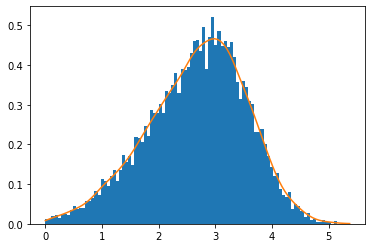

Histogram for F Test feature  1


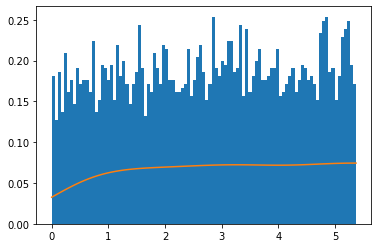

Histogram for F Test feature  2


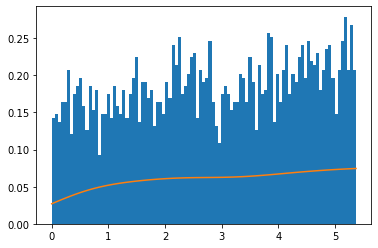

Histogram for F Test feature  3


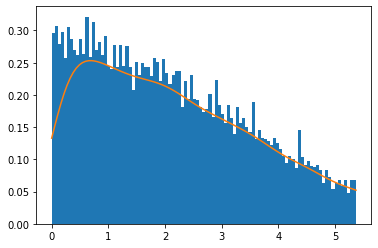

Histogram for F Test feature  4


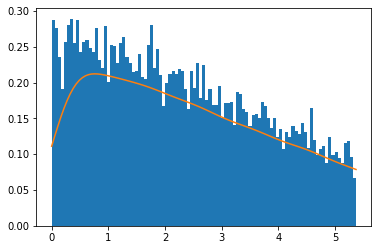

Histogram for F Test feature  5


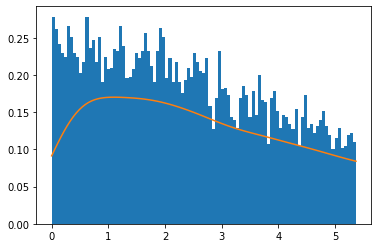

Histogram for F Test feature  6


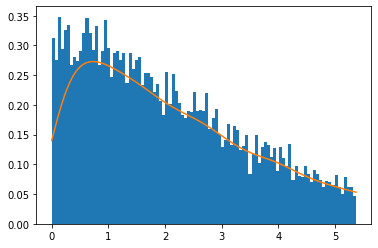

Histogram for F Test feature  7


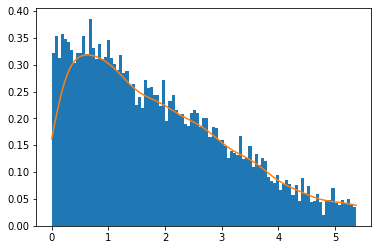

Histogram for F Test feature  8


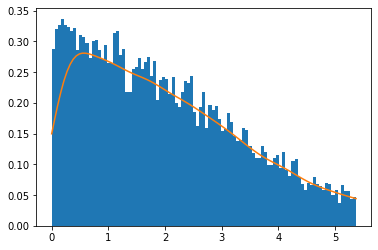

Histogram for F Test feature  9


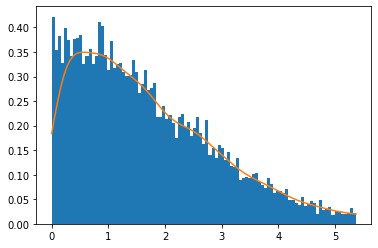

Histogram for F Test feature  10


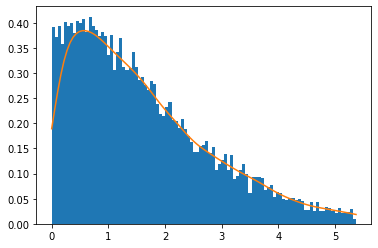

Histogram for F Test feature  11


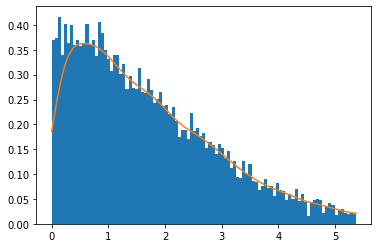

Histogram for F Test feature  12


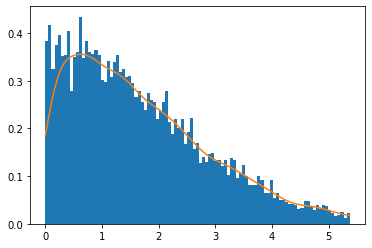

Histogram for F Test feature  13


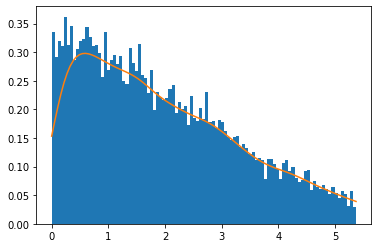

Histogram for F Test feature  14


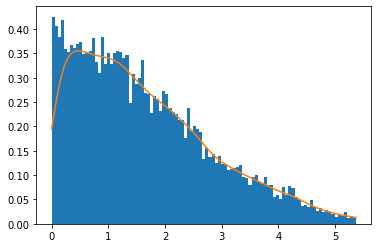

Histogram for F Test feature  15


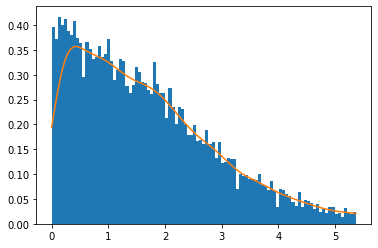

Histogram for F Test feature  16


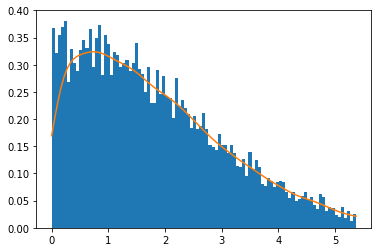

Histogram for F Test feature  17


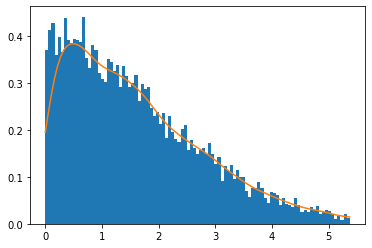

Histogram for F Test feature  18


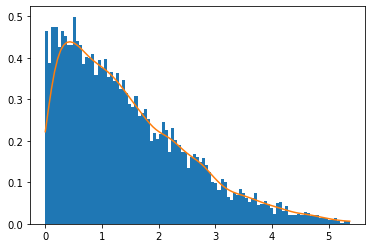

Histogram for F Test feature  19


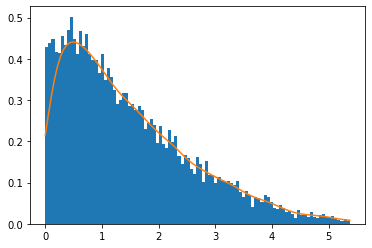

Histogram for F Test feature  20


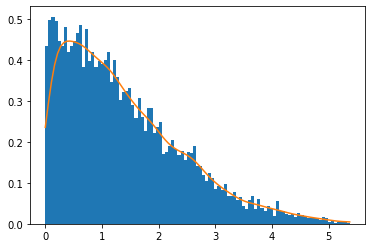

Histogram for F Test feature  21


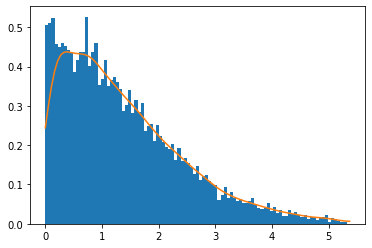

Histogram for F Test feature  22


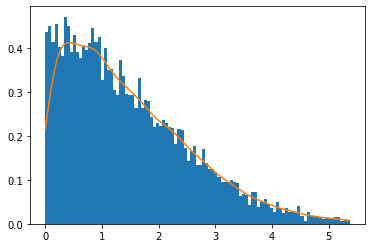

Histogram for F Test feature  23


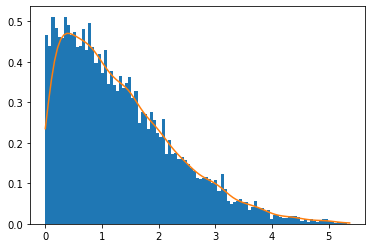

Histogram for F Test feature  24


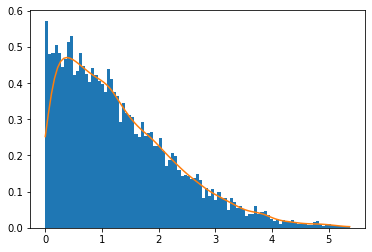

Histogram for F Test feature  25


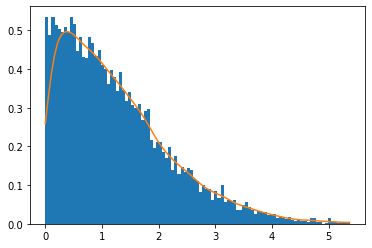

Histogram for F Test feature  26


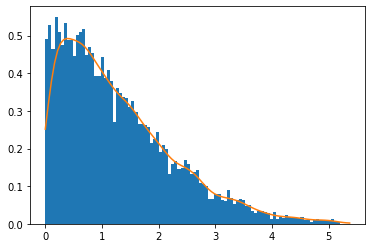

Histogram for F Test feature  27


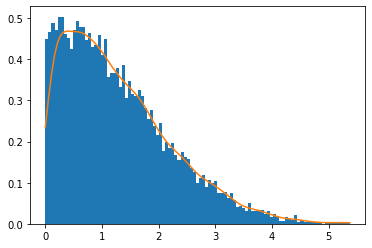

Histogram for F Test feature  28


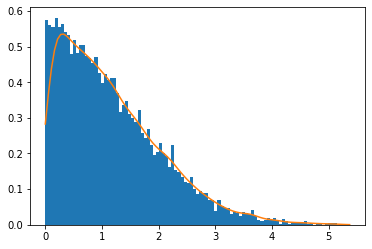

Histogram for F Test feature  29


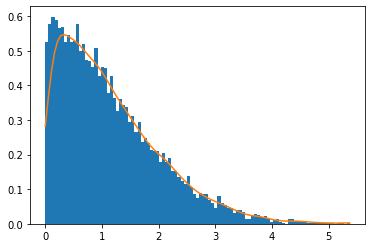

Histogram for F Test feature  30


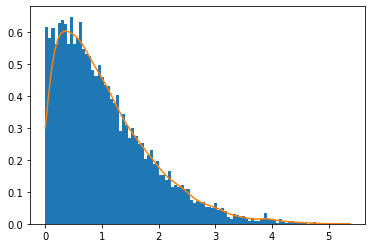

Histogram for F Test feature  31


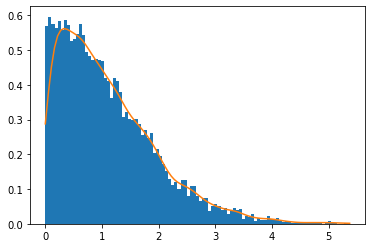

Histogram for F Test feature  32


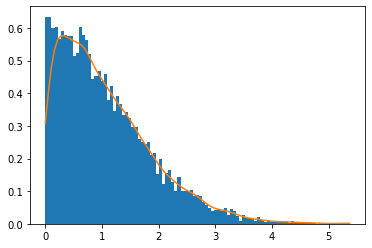

Histogram for F Test feature  33


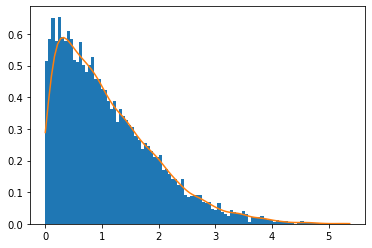

Histogram for F Test feature  34


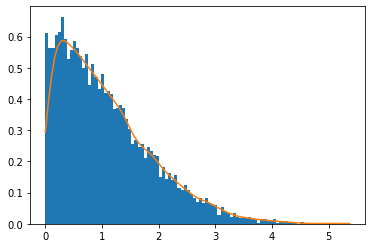

Histogram for F Test feature  35


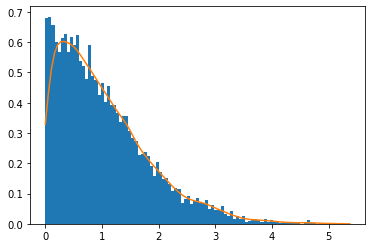

Histogram for F Test feature  36


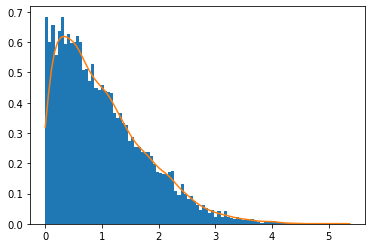

Histogram for F Test feature  37


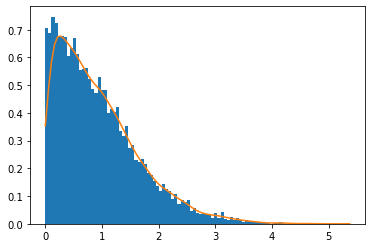

Histogram for F Test feature  38


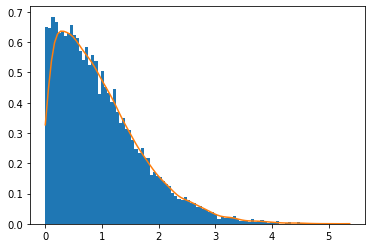

Histogram for F Test feature  39


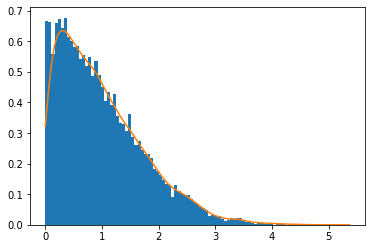

Histogram for F Test feature  40


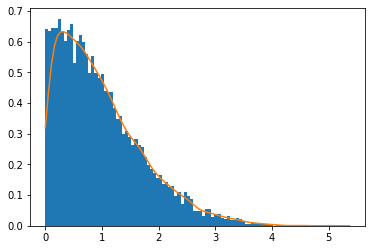

Histogram for F Test feature  41


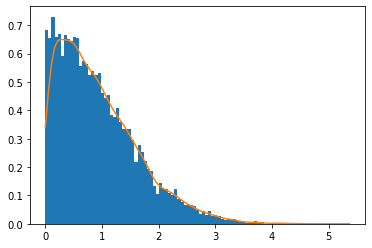

Histogram for F Test feature  42


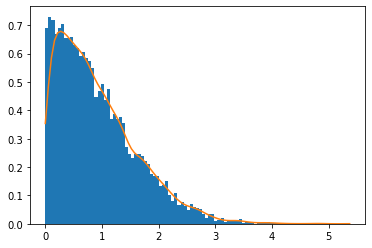

Histogram for F Test feature  43


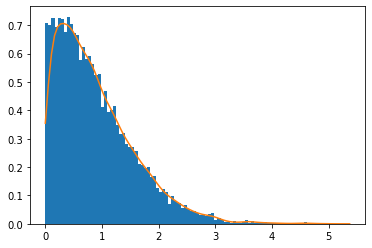

Histogram for F Test feature  44


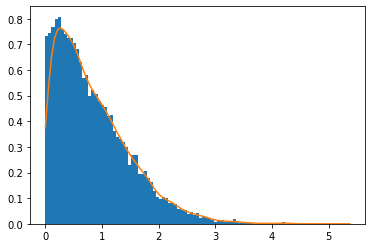

Histogram for F Test feature  45


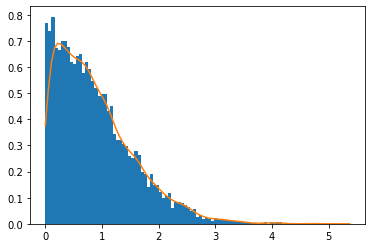

Histogram for F Test feature  46


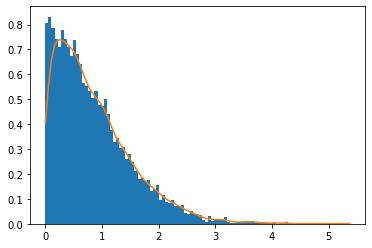

Histogram for F Test feature  47


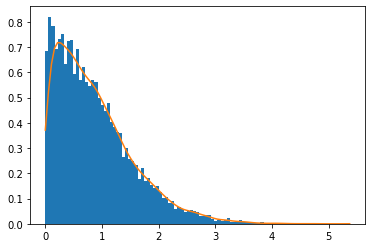

Histogram for F Test feature  48


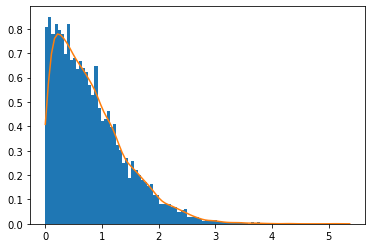

Histogram for F Test feature  49


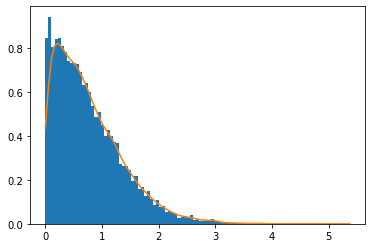

Histogram for F Test feature  50


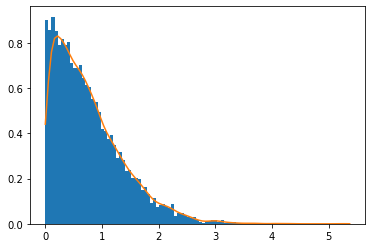

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.6076
LR Accuracy on test data - All features:  0.3387
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6067
Logistic Regression Accuracy on test data - rotated:  0.3397
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.3445
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6085
Logistic Regression Accuracy on test data - rotated:  0.3093
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6018
Logistic Regression Accuracy on test data - rotated:  0.264
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6045
Logistic Regression Accuracy on test data - rotated:  0.2816
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6037
Logistic Regression Accuracy on test data - rotated:  0.325
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6071
Logistic Regression Accuracy on test data - rotated:  0.3139
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3228
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6043
Logistic Regression Accuracy on test data - rotated:  0.3364
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.604
Logistic Regression Accuracy on test data - rotated:  0.3389
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6027
Logistic Regression Accuracy on test data - rotated:  0.3194
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6072
Logistic Regression Accuracy on test data - rotated:  0.3309
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3313
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6059
Logistic Regression Accuracy on test data - rotated:  0.3256
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6051
Logistic Regression Accuracy on test data - rotated:  0.3253
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.607
Logistic Regression Accuracy on test data - rotated:  0.3299
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6063
Logistic Regression Accuracy on test data - rotated:  0.3356
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.608
Logistic Regression Accuracy on test data - rotated:  0.3427
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6026
Logistic Regression Accuracy on test data - rotated:  0.3143
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6069
Logistic Regression Accuracy on test data - rotated:  0.3344
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.3421
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6052
Logistic Regression Accuracy on test data - rotated:  0.3532
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6034
Logistic Regression Accuracy on test data - rotated:  0.3429
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6055
Logistic Regression Accuracy on test data - rotated:  0.332
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6108
Logistic Regression Accuracy on test data - rotated:  0.3339
Accuracy for without feature  25


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6072
Logistic Regression Accuracy on test data - rotated:  0.3388
Accuracy for without feature  26


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6038
Logistic Regression Accuracy on test data - rotated:  0.3402
Accuracy for without feature  27


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6033
Logistic Regression Accuracy on test data - rotated:  0.324
Accuracy for without feature  28


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3259
Accuracy for without feature  29


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6066
Logistic Regression Accuracy on test data - rotated:  0.3382
Accuracy for without feature  30


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3433
Accuracy for without feature  31


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6048
Logistic Regression Accuracy on test data - rotated:  0.3401
Accuracy for without feature  32


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6052
Logistic Regression Accuracy on test data - rotated:  0.3388
Accuracy for without feature  33


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6079
Logistic Regression Accuracy on test data - rotated:  0.3487
Accuracy for without feature  34


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.607
Logistic Regression Accuracy on test data - rotated:  0.3407
Accuracy for without feature  35


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.606
Logistic Regression Accuracy on test data - rotated:  0.3395
Accuracy for without feature  36


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3383
Accuracy for without feature  37


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6067
Logistic Regression Accuracy on test data - rotated:  0.3428
Accuracy for without feature  38


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6094
Logistic Regression Accuracy on test data - rotated:  0.3404
Accuracy for without feature  39


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6081
Logistic Regression Accuracy on test data - rotated:  0.3342
Accuracy for without feature  40


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6053
Logistic Regression Accuracy on test data - rotated:  0.3436
Accuracy for without feature  41


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6071
Logistic Regression Accuracy on test data - rotated:  0.3411
Accuracy for without feature  42


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6071
Logistic Regression Accuracy on test data - rotated:  0.3417
Accuracy for without feature  43


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6079
Logistic Regression Accuracy on test data - rotated:  0.3393
Accuracy for without feature  44


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6059
Logistic Regression Accuracy on test data - rotated:  0.3325
Accuracy for without feature  45


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3401
Accuracy for without feature  46


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6079
Logistic Regression Accuracy on test data - rotated:  0.3425
Accuracy for without feature  47


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6067
Logistic Regression Accuracy on test data - rotated:  0.3405
Accuracy for without feature  48


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6103
Logistic Regression Accuracy on test data - rotated:  0.3432
Accuracy for without feature  49


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6054
Logistic Regression Accuracy on test data - rotated:  0.3386
Accuracy for without feature  50


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.3357




Results for lamda  0.01

Printing eigenvalues
(512,)
[-2.60302321e+02 -4.27144739e+01 -2.10221317e+01 -2.01594079e+01
 -1.52196872e+01 -1.30776008e+01 -1.17874786e+01 -8.66157699e+00
 -7.89511008e+00 -6.73473371e+00 -6.23721526e+00 -5.46592347e+00
 -5.04105509e+00 -4.76530082e+00 -4.52617217e+00 -3.97391987e+00
 -3.30709799e+00 -3.27627326e+00 -2.80518625e+00 -2.77636211e+00
 -2.58625531e+00 -2.55547310e+00 -2.36298071e+00 -2.19128757e+00
 -2.09753991e+00 -2.05968000e+00 -1.98077272e+00 -1.80724658e+00
 -1.78247970e+00 -1.59447438e+00 -1.51458656e+00 -1.45858922e+00
 -1.40138187e+00 -1.28619404e+00 -1.24646338e+00 -1.21569466e+00
 -1.15670994e+00 -1.12289643e+00 -1.09457344e+00 -1.04271396e+00
 -1.00222935e+00 -9.50837968e-01 -9.47169178e-01 -8.95491408e-01
 -8.69813898e-01 -8.47649001e-01 -8.14777362e-01 -8.12102659e-01
 -7.75719110e-01 -7.38238118e

(512, 512)

array([[-0.04568579,  0.03014845, -0.00174392, ...,  0.00140415,
        -0.05305136, -0.01026505],
       [-0.12040618,  0.09104563, -0.14726927, ..., -0.00128554,
        -0.0098606 , -0.02222387],
       [-0.07744705,  0.08651379, -0.08511257, ..., -0.00088943,
         0.02565255, -0.04768   ],
       ...,
       [-0.0256013 , -0.02593342,  0.0089613 , ...,  0.00122765,
        -0.0073784 ,  0.01064134],
       [-0.0160849 , -0.02946437,  0.02199575, ..., -0.00038217,
         0.04959228, -0.03186726],
       [-0.0062153 , -0.0068867 ,  0.01258816, ...,  0.01579267,
        -0.01849494, -0.02401494]])

Printing least k eigenvalues before removing the zero eigenvalue
[-260.30232119  -42.71447389  -21.02213172  -20.15940795  -15.21968715
  -13.07760083  -11.78747859   -8.66157699   -7.89511008   -6.73473371
   -6.23721526   -5.46592347   -5.04105509   -4.76530082   -4.52617217
   -3.97391987   -3.30709799   -3.27627326   -2.80518625   -2.77636211
   -2.58625531   -2.5554731    -2.36298071   -2.19128757   -2.09753991
   -2.05968      -1.98077272   -1.80724658   -1.7824797    -1.59447438
   -1.51458656   -1.45858922   -1.40138187   -1.28619404   -1.24646338
   -1.21569466   -1.15670994   -1.12289643   -1.09457344   -1.04271396
   -1.00222935   -0.95083797   -0.94716918   -0.89549141   -0.8698139
   -0.847649     -0.81477736   -0.81210266   -0.77571911   -0.73823812
   -0.72392751]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-260.30232119  -42.71447389  -21.02213172  -20.15940795  -15.21968715
  -13.07760083  -11.78747859   -8.66157699   -7.89511008   -6.73473371
  

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,3.014026,10.941410,7.817971,2.117594,5.374253,3.828432,2.156065,1.834216,2.113058,3.394524,...,1.876616,0.983193,1.396318,1.653331,0.222306,0.408537,0.411578,0.800134,0.287866,0.278958
1,2.435494,5.421565,3.312331,2.909299,5.286104,3.736760,7.173012,4.982799,8.475011,2.237245,...,1.954326,1.019054,2.296715,0.090052,0.577829,1.399009,0.812129,0.186223,0.358800,0.692808
2,3.148465,4.913273,2.643456,7.915698,6.716691,8.450503,6.829776,6.610596,0.856612,0.557638,...,0.560990,0.735472,0.068886,1.807525,0.169007,1.349904,0.004435,0.975160,0.745215,0.018478
3,3.554349,12.242479,10.930374,1.451052,5.961979,4.491831,4.589801,2.444886,3.569886,2.886506,...,1.238065,1.113775,0.249686,0.937675,0.221385,0.537035,1.258148,1.166133,0.409744,0.279808
4,2.496241,7.506928,4.040371,3.083212,2.452232,3.918655,2.113521,0.556941,0.173263,0.051592,...,1.242771,1.121303,1.226831,0.248143,0.337984,0.168719,0.608728,1.030672,0.861407,0.947355


Histogram for F Test feature  0


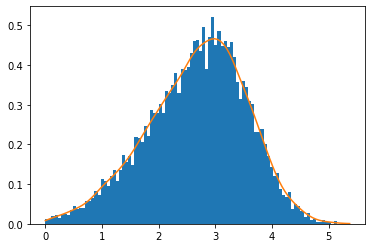

Histogram for F Test feature  1


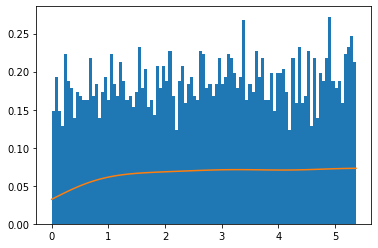

Histogram for F Test feature  2


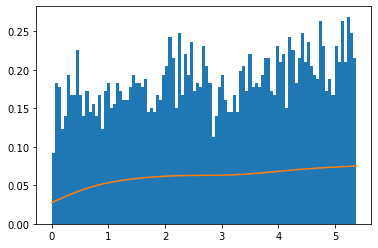

Histogram for F Test feature  3


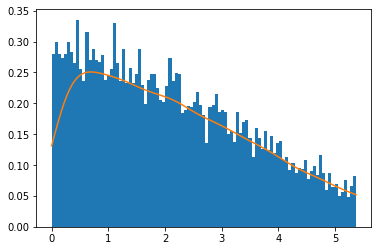

Histogram for F Test feature  4


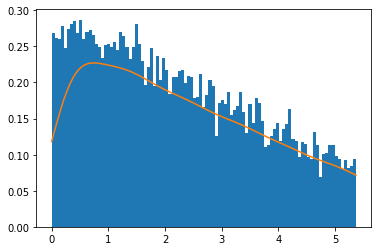

Histogram for F Test feature  5


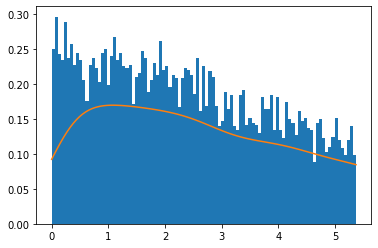

Histogram for F Test feature  6


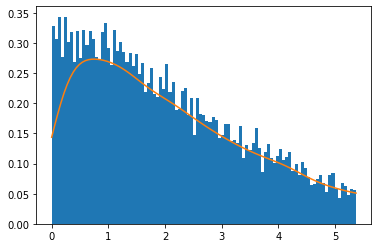

Histogram for F Test feature  7


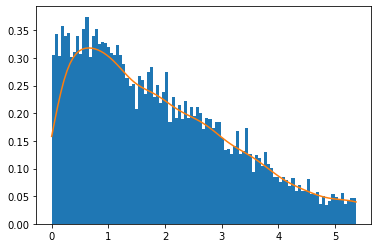

Histogram for F Test feature  8


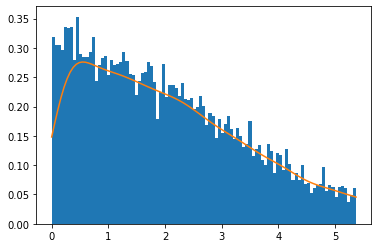

Histogram for F Test feature  9


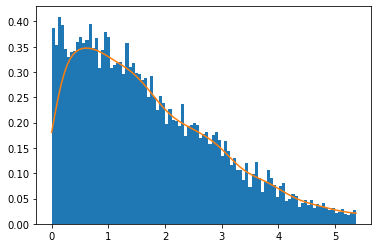

Histogram for F Test feature  10


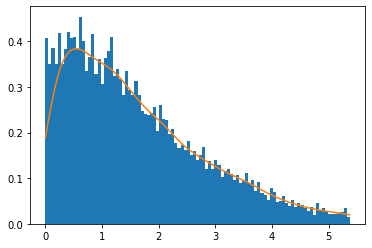

Histogram for F Test feature  11


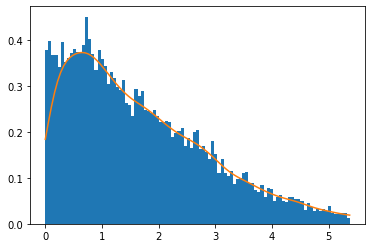

Histogram for F Test feature  12


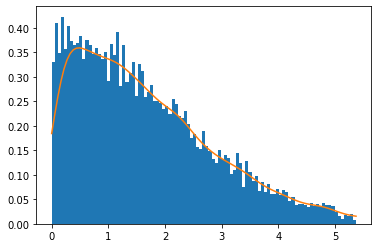

Histogram for F Test feature  13


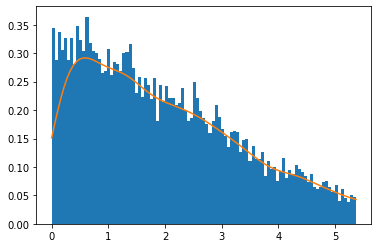

Histogram for F Test feature  14


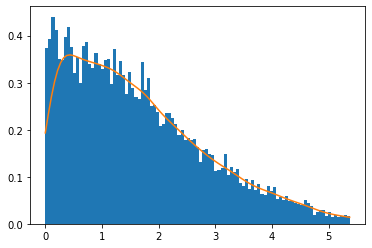

Histogram for F Test feature  15


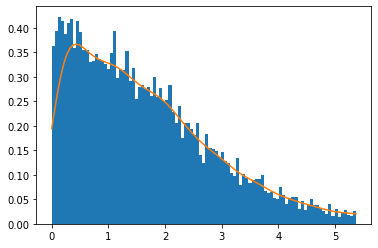

Histogram for F Test feature  16


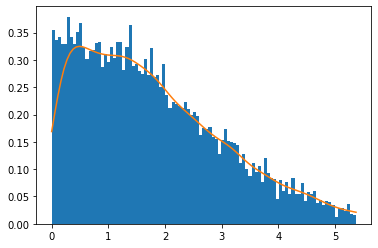

Histogram for F Test feature  17


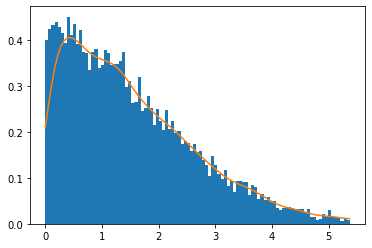

Histogram for F Test feature  18


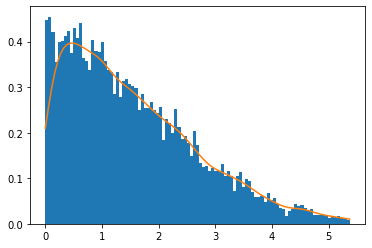

Histogram for F Test feature  19


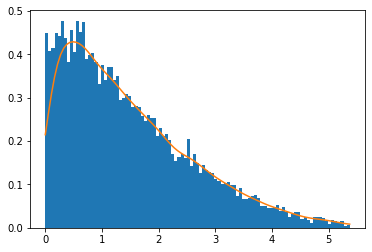

Histogram for F Test feature  20


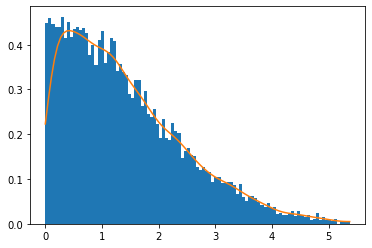

Histogram for F Test feature  21


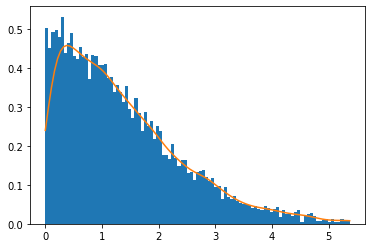

Histogram for F Test feature  22


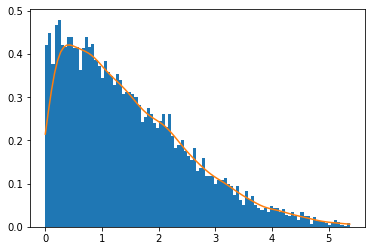

Histogram for F Test feature  23


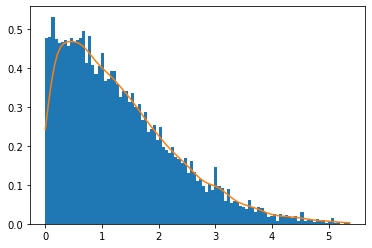

Histogram for F Test feature  24


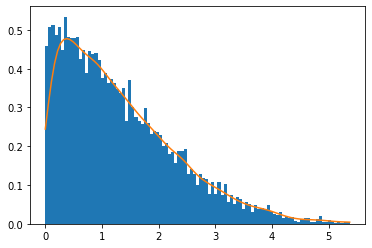

Histogram for F Test feature  25


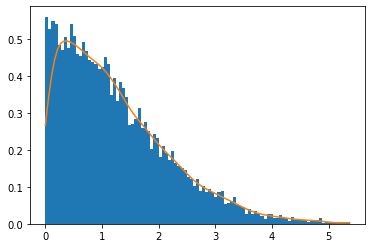

Histogram for F Test feature  26


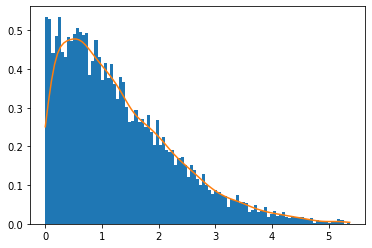

Histogram for F Test feature  27


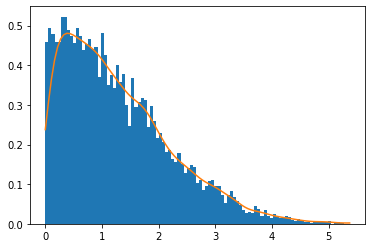

Histogram for F Test feature  28


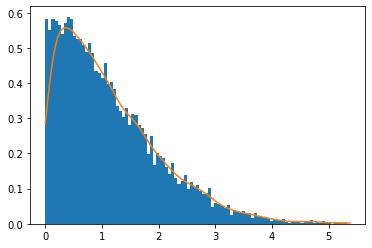

Histogram for F Test feature  29


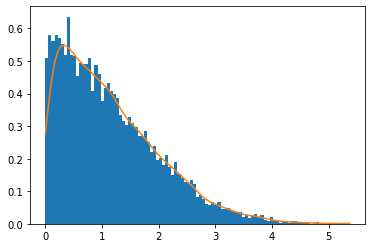

Histogram for F Test feature  30


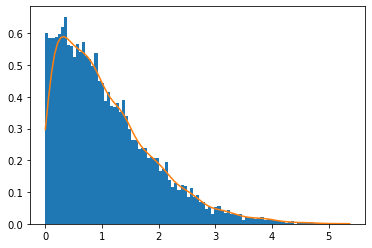

Histogram for F Test feature  31


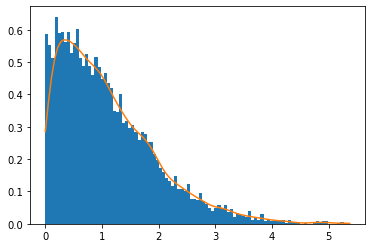

Histogram for F Test feature  32


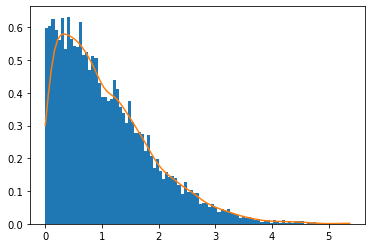

Histogram for F Test feature  33


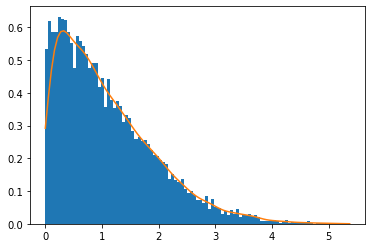

Histogram for F Test feature  34


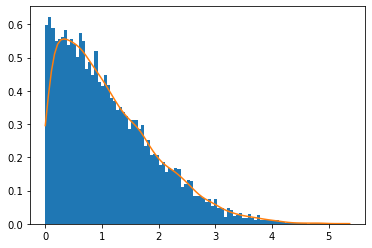

Histogram for F Test feature  35


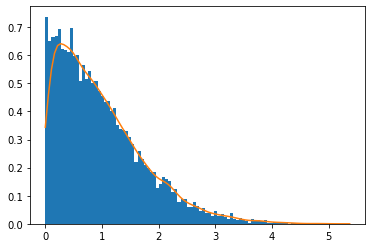

Histogram for F Test feature  36


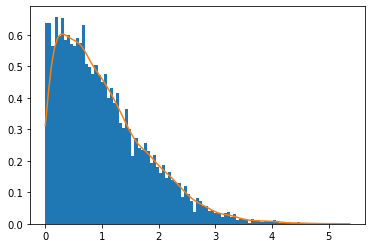

Histogram for F Test feature  37


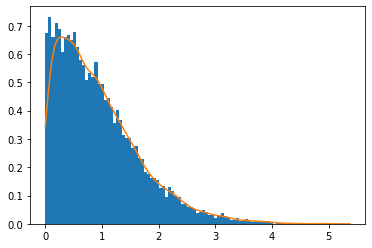

Histogram for F Test feature  38


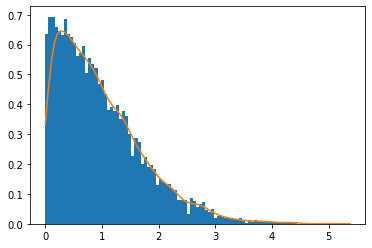

Histogram for F Test feature  39


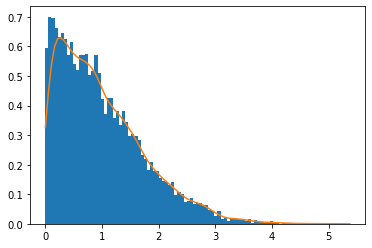

Histogram for F Test feature  40


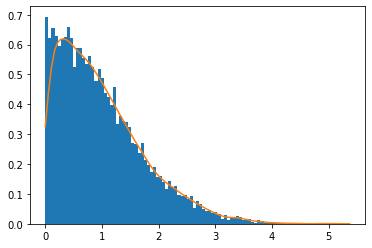

Histogram for F Test feature  41


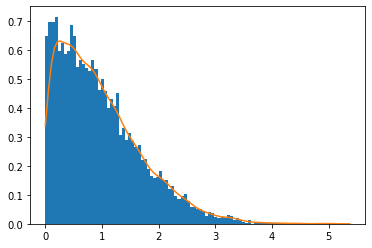

Histogram for F Test feature  42


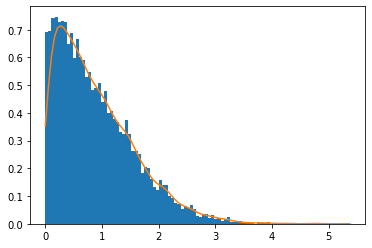

Histogram for F Test feature  43


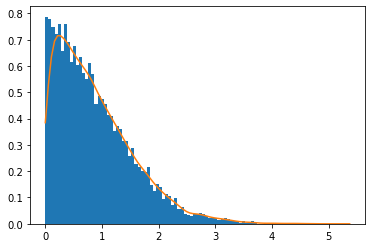

Histogram for F Test feature  44


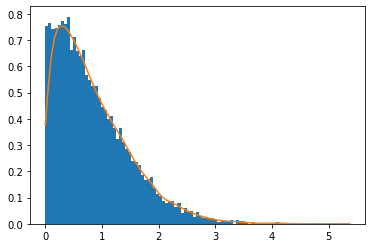

Histogram for F Test feature  45


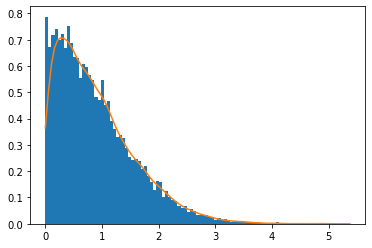

Histogram for F Test feature  46


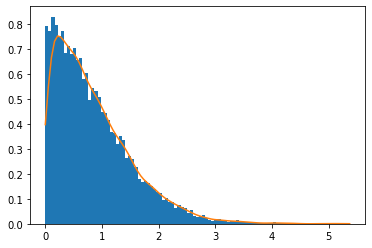

Histogram for F Test feature  47


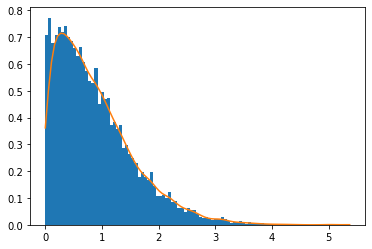

Histogram for F Test feature  48


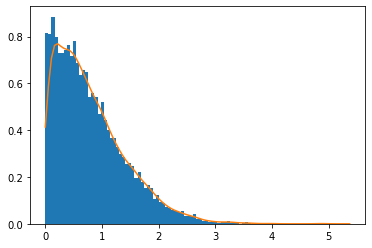

Histogram for F Test feature  49


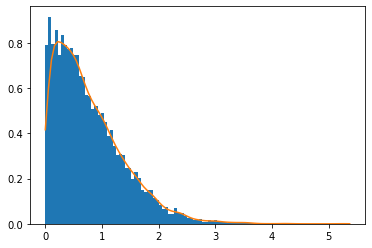

Histogram for F Test feature  50


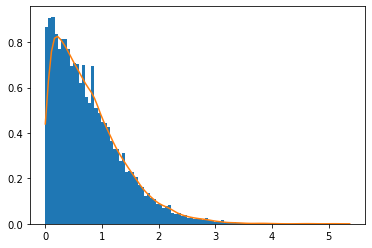

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.6081
LR Accuracy on test data - All features:  0.341
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3398
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6089
Logistic Regression Accuracy on test data - rotated:  0.3478
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6082
Logistic Regression Accuracy on test data - rotated:  0.3096
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.603
Logistic Regression Accuracy on test data - rotated:  0.2651
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6047
Logistic Regression Accuracy on test data - rotated:  0.275
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6015
Logistic Regression Accuracy on test data - rotated:  0.3194
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6061
Logistic Regression Accuracy on test data - rotated:  0.3178
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6078
Logistic Regression Accuracy on test data - rotated:  0.3225
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6045
Logistic Regression Accuracy on test data - rotated:  0.3381
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6044
Logistic Regression Accuracy on test data - rotated:  0.3417
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6039
Logistic Regression Accuracy on test data - rotated:  0.3184
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6066
Logistic Regression Accuracy on test data - rotated:  0.3281
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6074
Logistic Regression Accuracy on test data - rotated:  0.332
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6032
Logistic Regression Accuracy on test data - rotated:  0.3269
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6046
Logistic Regression Accuracy on test data - rotated:  0.3246
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3304
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6072
Logistic Regression Accuracy on test data - rotated:  0.3377
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6057
Logistic Regression Accuracy on test data - rotated:  0.3434
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6061
Logistic Regression Accuracy on test data - rotated:  0.3236
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6064
Logistic Regression Accuracy on test data - rotated:  0.3385
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6091
Logistic Regression Accuracy on test data - rotated:  0.3424
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.604
Logistic Regression Accuracy on test data - rotated:  0.3561
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6054
Logistic Regression Accuracy on test data - rotated:  0.3436
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6054
Logistic Regression Accuracy on test data - rotated:  0.3328
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6077
Logistic Regression Accuracy on test data - rotated:  0.3345
Accuracy for without feature  25


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6071
Logistic Regression Accuracy on test data - rotated:  0.3431
Accuracy for without feature  26


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6031
Logistic Regression Accuracy on test data - rotated:  0.3405
Accuracy for without feature  27


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6046
Logistic Regression Accuracy on test data - rotated:  0.3247
Accuracy for without feature  28


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6069
Logistic Regression Accuracy on test data - rotated:  0.3408
Accuracy for without feature  29


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.327
Accuracy for without feature  30


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6083
Logistic Regression Accuracy on test data - rotated:  0.3463
Accuracy for without feature  31


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6041
Logistic Regression Accuracy on test data - rotated:  0.3444
Accuracy for without feature  32


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6051
Logistic Regression Accuracy on test data - rotated:  0.3436
Accuracy for without feature  33


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.607
Logistic Regression Accuracy on test data - rotated:  0.3488
Accuracy for without feature  34


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.3452
Accuracy for without feature  35


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6072
Logistic Regression Accuracy on test data - rotated:  0.3437
Accuracy for without feature  36


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3386
Accuracy for without feature  37


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6058
Logistic Regression Accuracy on test data - rotated:  0.3438
Accuracy for without feature  38


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6093
Logistic Regression Accuracy on test data - rotated:  0.3422
Accuracy for without feature  39


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6075
Logistic Regression Accuracy on test data - rotated:  0.3344
Accuracy for without feature  40


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6049
Logistic Regression Accuracy on test data - rotated:  0.3426
Accuracy for without feature  41


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6078
Logistic Regression Accuracy on test data - rotated:  0.3438
Accuracy for without feature  42


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6065
Logistic Regression Accuracy on test data - rotated:  0.3452
Accuracy for without feature  43


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6075
Logistic Regression Accuracy on test data - rotated:  0.3382
Accuracy for without feature  44


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.605
Logistic Regression Accuracy on test data - rotated:  0.3341
Accuracy for without feature  45


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.605
Logistic Regression Accuracy on test data - rotated:  0.34
Accuracy for without feature  46


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6071
Logistic Regression Accuracy on test data - rotated:  0.3445
Accuracy for without feature  47


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6072
Logistic Regression Accuracy on test data - rotated:  0.3416
Accuracy for without feature  48


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6091
Logistic Regression Accuracy on test data - rotated:  0.3431
Accuracy for without feature  49


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6063
Logistic Regression Accuracy on test data - rotated:  0.3402
Accuracy for without feature  50


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6075
Logistic Regression Accuracy on test data - rotated:  0.3399




Results for lamda  0.001

Printing eigenvalues
(512,)
[-2.62258919e+02 -4.28329327e+01 -2.10829066e+01 -2.02189492e+01
 -1.52682311e+01 -1.31319285e+01 -1.18210020e+01 -8.69005020e+00
 -7.92116524e+00 -6.75413916e+00 -6.26222953e+00 -5.48732485e+00
 -5.06248391e+00 -4.78395383e+00 -4.54074250e+00 -3.99029057e+00
 -3.31891018e+00 -3.28831127e+00 -2.81440417e+00 -2.78983716e+00
 -2.59544327e+00 -2.56647020e+00 -2.37156058e+00 -2.20107344e+00
 -2.10816116e+00 -2.06856323e+00 -1.98898189e+00 -1.81816217e+00
 -1.79040918e+00 -1.60202834e+00 -1.52148076e+00 -1.46549253e+00
 -1.40808318e+00 -1.29391355e+00 -1.25358093e+00 -1.22175059e+00
 -1.16280502e+00 -1.13028715e+00 -1.10151164e+00 -1.04990199e+00
 -1.01062685e+00 -9.56630927e-01 -9.54375527e-01 -8.99974716e-01
 -8.76147641e-01 -8.52423023e-01 -8.19726068e-01 -8.18031325e-01
 -7.80256336e-01 -7.43295382

(512, 512)

array([[-4.57514997e-02,  3.01579107e-02, -1.82152713e-03, ...,
         6.08717674e-03, -1.51616326e-03,  5.30513662e-02],
       [-1.20326348e-01,  9.05644933e-02, -1.46646636e-01, ...,
         3.99569699e-04,  1.03662099e-03,  9.86060436e-03],
       [-7.77326433e-02,  8.66407019e-02, -8.54429127e-02, ...,
         3.02180547e-03,  5.51553569e-04, -2.56525486e-02],
       ...,
       [-2.56458872e-02, -2.58908171e-02,  9.13360570e-03, ...,
         1.93565660e-03, -1.01861450e-03,  7.37840142e-03],
       [-1.62424247e-02, -2.91693787e-02,  2.20477112e-02, ...,
         1.15683397e-02,  7.25650615e-05, -4.95922804e-02],
       [-6.23946093e-03, -6.90240158e-03,  1.26614251e-02, ...,
        -1.23107793e-02, -1.60148995e-02,  1.84949439e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[-262.25891908  -42.83293268  -21.08290655  -20.21894918  -15.26823112
  -13.13192848  -11.821002     -8.6900502    -7.92116524   -6.75413916
   -6.26222953   -5.48732485   -5.06248391   -4.78395383   -4.5407425
   -3.99029057   -3.31891018   -3.28831127   -2.81440417   -2.78983716
   -2.59544327   -2.5664702    -2.37156058   -2.20107344   -2.10816116
   -2.06856323   -1.98898189   -1.81816217   -1.79040918   -1.60202834
   -1.52148076   -1.46549253   -1.40808318   -1.29391355   -1.25358093
   -1.22175059   -1.16280502   -1.13028715   -1.10151164   -1.04990199
   -1.01062685   -0.95663093   -0.95437553   -0.89997472   -0.87614764
   -0.85242302   -0.81972607   -0.81803133   -0.78025634   -0.74329538
   -0.72959079]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-262.25891908  -42.83293268  -21.08290655  -20.21894918  -15.26823112
  -13.13192848  -11.821002     -8.6900502    -7.92116524   -6.75413916
  

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,3.014026,10.956721,7.812338,2.133837,5.347513,3.836888,2.157683,1.821091,2.121607,3.389290,...,1.837384,1.744355,0.290927,1.645523,0.227015,0.418794,0.475492,0.750716,0.308923,0.234499
1,2.435494,5.432981,3.312223,2.897926,5.297502,3.668694,7.179493,5.003339,8.483694,2.220404,...,1.669236,2.475686,0.927376,0.096410,0.586507,1.397407,0.871743,0.148251,0.382113,0.574230
2,3.148465,4.923709,2.638088,7.903117,6.742637,8.404665,6.853527,6.627814,0.876593,0.538008,...,0.535525,0.485012,0.559893,1.805366,0.173336,1.346656,0.052174,0.961864,0.754015,0.030706
3,3.554349,12.263337,10.925453,1.464977,5.936812,4.462590,4.599309,2.460210,3.587483,2.870148,...,1.187661,0.504632,1.016794,0.944870,0.215274,0.546622,1.230677,1.239234,0.373394,0.314734
4,2.496241,7.507963,4.026366,3.062144,2.485316,3.910016,2.129945,0.547427,0.195358,0.064939,...,1.166573,1.701257,0.083219,0.244740,0.313583,0.149017,0.499653,1.043052,0.883485,1.038244


Histogram for F Test feature  0


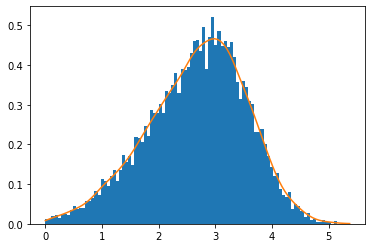

Histogram for F Test feature  1


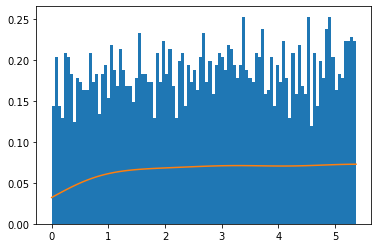

Histogram for F Test feature  2


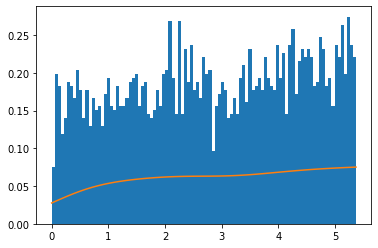

Histogram for F Test feature  3


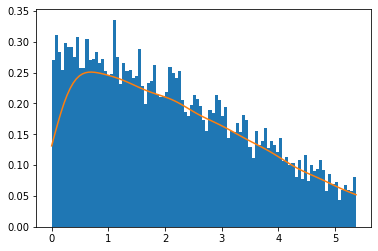

Histogram for F Test feature  4


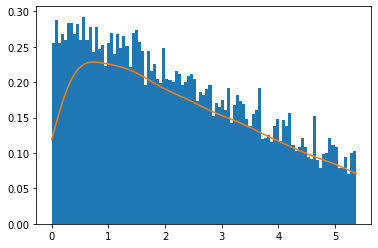

Histogram for F Test feature  5


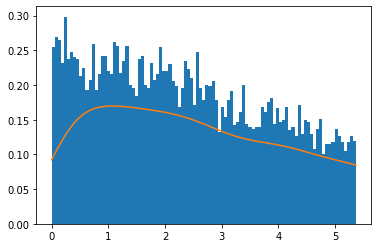

Histogram for F Test feature  6


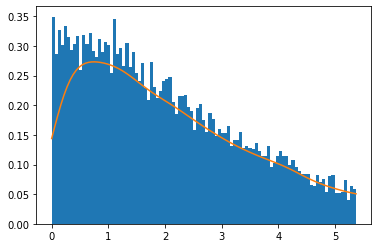

Histogram for F Test feature  7


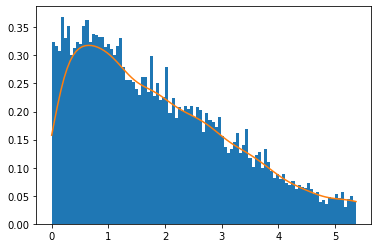

Histogram for F Test feature  8


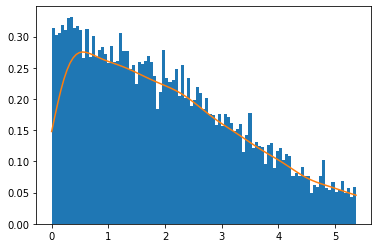

Histogram for F Test feature  9


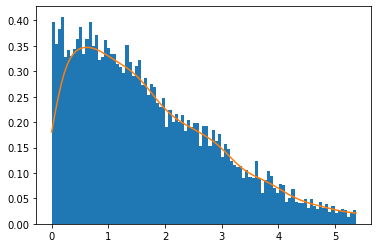

Histogram for F Test feature  10


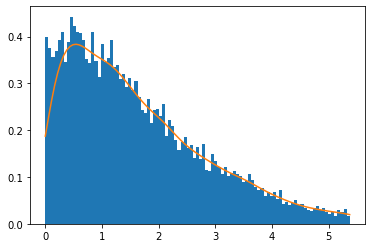

Histogram for F Test feature  11


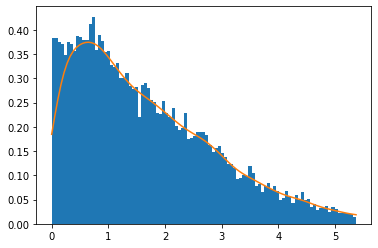

Histogram for F Test feature  12


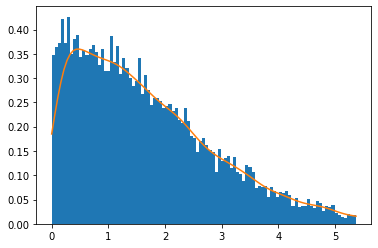

Histogram for F Test feature  13


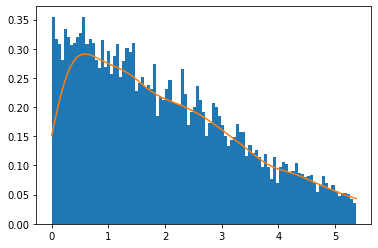

Histogram for F Test feature  14


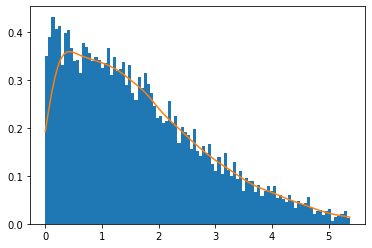

Histogram for F Test feature  15


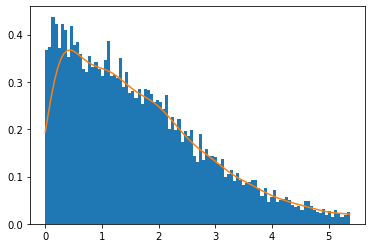

Histogram for F Test feature  16


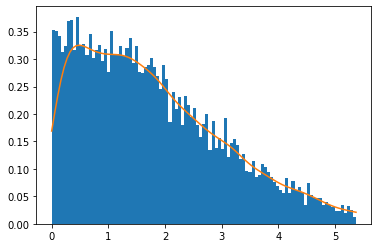

Histogram for F Test feature  17


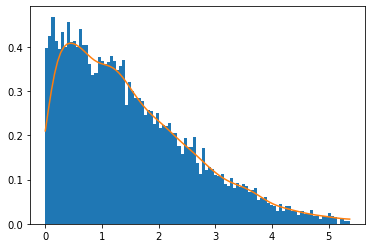

Histogram for F Test feature  18


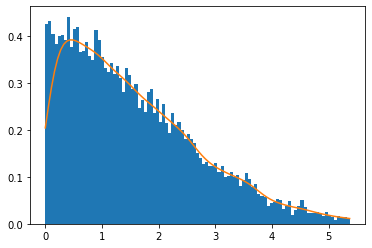

Histogram for F Test feature  19


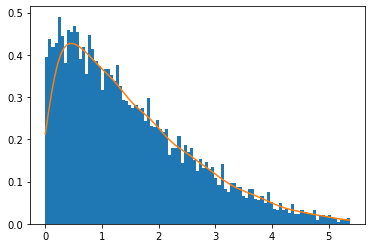

Histogram for F Test feature  20


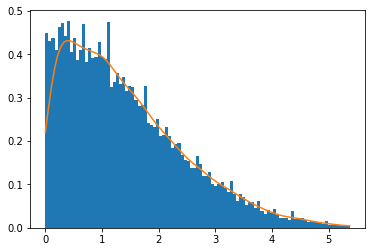

Histogram for F Test feature  21


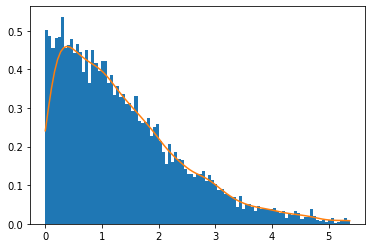

Histogram for F Test feature  22


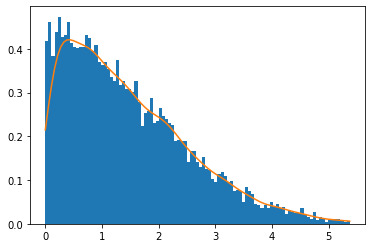

Histogram for F Test feature  23


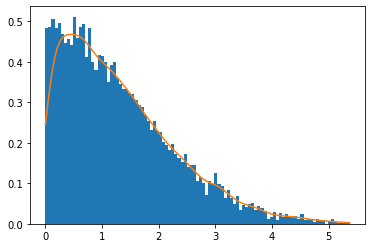

Histogram for F Test feature  24


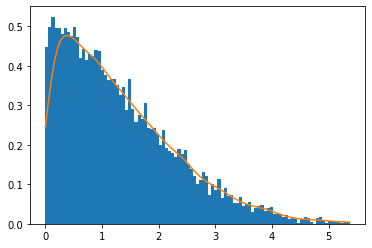

Histogram for F Test feature  25


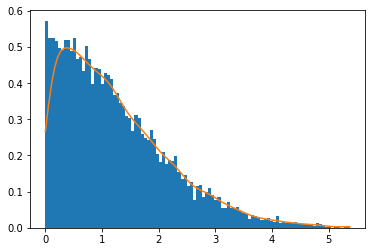

Histogram for F Test feature  26


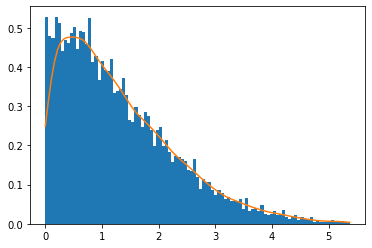

Histogram for F Test feature  27


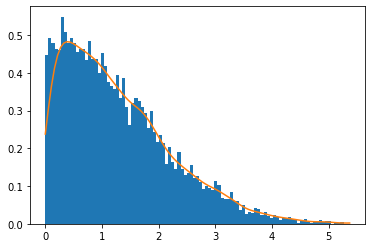

Histogram for F Test feature  28


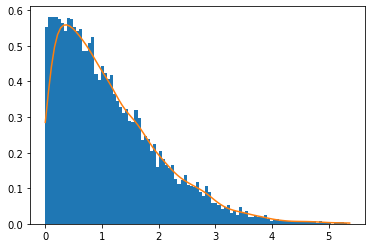

Histogram for F Test feature  29


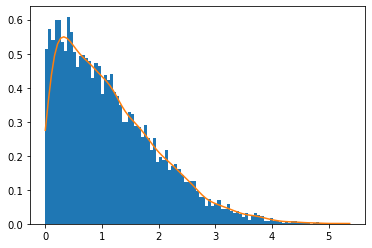

Histogram for F Test feature  30


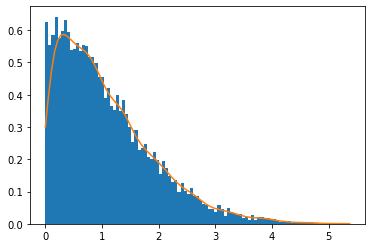

Histogram for F Test feature  31


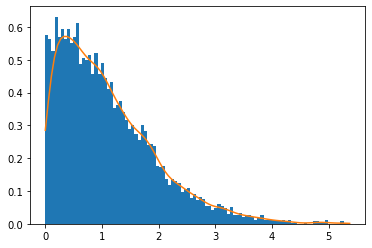

Histogram for F Test feature  32


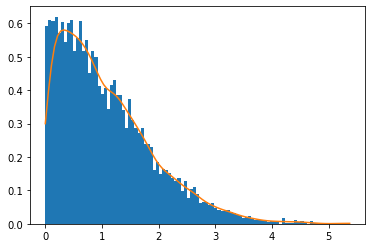

Histogram for F Test feature  33


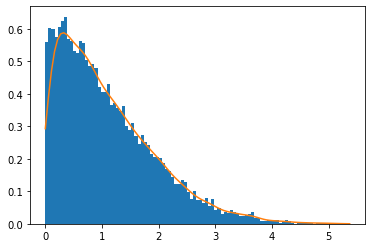

Histogram for F Test feature  34


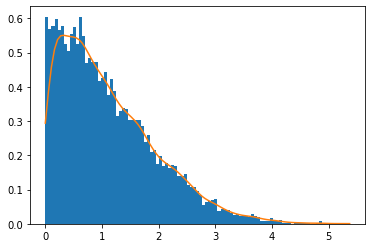

Histogram for F Test feature  35


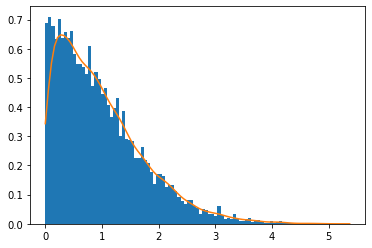

Histogram for F Test feature  36


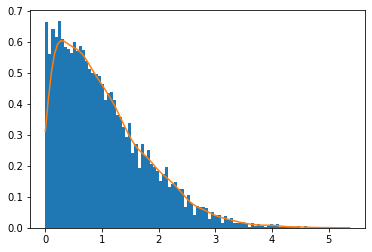

Histogram for F Test feature  37


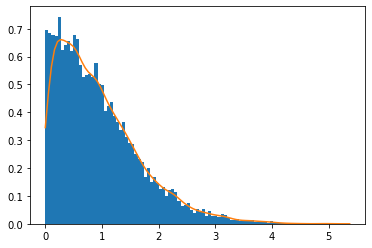

Histogram for F Test feature  38


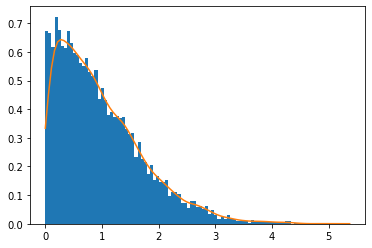

Histogram for F Test feature  39


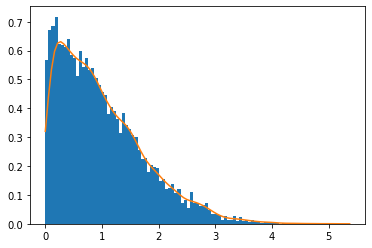

Histogram for F Test feature  40


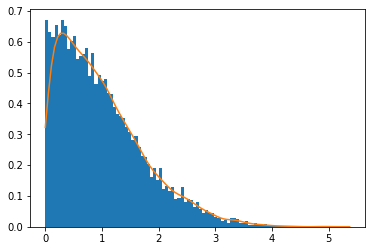

Histogram for F Test feature  41


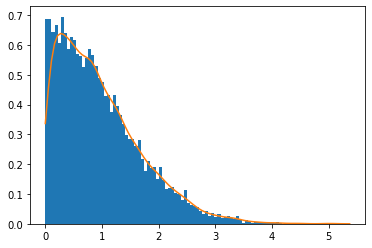

Histogram for F Test feature  42


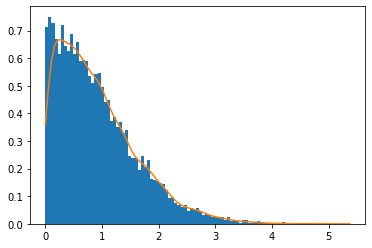

Histogram for F Test feature  43


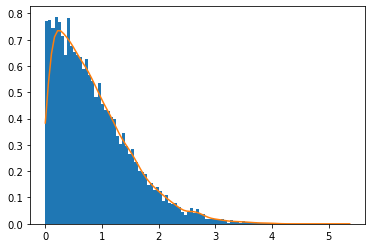

Histogram for F Test feature  44


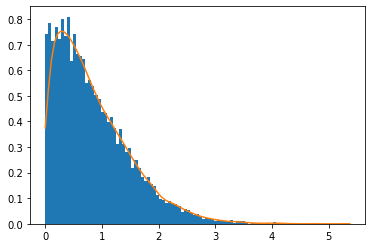

Histogram for F Test feature  45


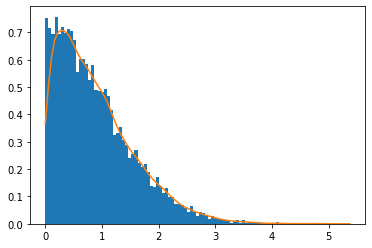

Histogram for F Test feature  46


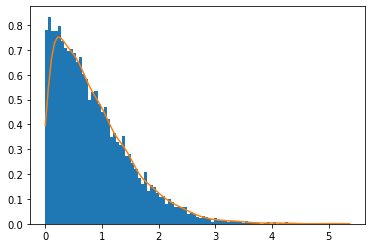

Histogram for F Test feature  47


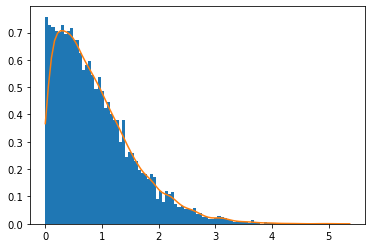

Histogram for F Test feature  48


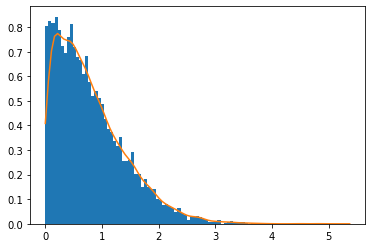

Histogram for F Test feature  49


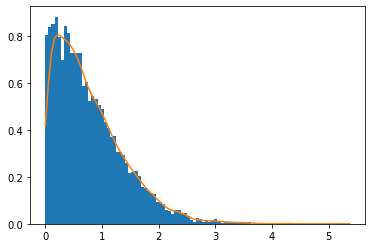

Histogram for F Test feature  50


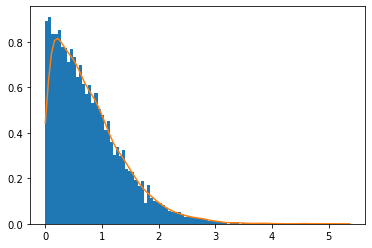

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.608
LR Accuracy on test data - All features:  0.3429
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.606
Logistic Regression Accuracy on test data - rotated:  0.3398
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6095
Logistic Regression Accuracy on test data - rotated:  0.3485
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6074
Logistic Regression Accuracy on test data - rotated:  0.3095
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6026
Logistic Regression Accuracy on test data - rotated:  0.2664
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.2756
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.602
Logistic Regression Accuracy on test data - rotated:  0.3191
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6061
Logistic Regression Accuracy on test data - rotated:  0.3185
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6079
Logistic Regression Accuracy on test data - rotated:  0.322
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6055
Logistic Regression Accuracy on test data - rotated:  0.3394
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.605
Logistic Regression Accuracy on test data - rotated:  0.3416
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6031
Logistic Regression Accuracy on test data - rotated:  0.3184
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6075
Logistic Regression Accuracy on test data - rotated:  0.3294
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6069
Logistic Regression Accuracy on test data - rotated:  0.3317
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6031
Logistic Regression Accuracy on test data - rotated:  0.3281
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6054
Logistic Regression Accuracy on test data - rotated:  0.3262
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6079
Logistic Regression Accuracy on test data - rotated:  0.3312
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6061
Logistic Regression Accuracy on test data - rotated:  0.3381
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6055
Logistic Regression Accuracy on test data - rotated:  0.3423
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6055
Logistic Regression Accuracy on test data - rotated:  0.3244
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6057
Logistic Regression Accuracy on test data - rotated:  0.3392
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6097
Logistic Regression Accuracy on test data - rotated:  0.3428
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6042
Logistic Regression Accuracy on test data - rotated:  0.3532
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6045
Logistic Regression Accuracy on test data - rotated:  0.3433
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6055
Logistic Regression Accuracy on test data - rotated:  0.3333
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.3333
Accuracy for without feature  25


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6074
Logistic Regression Accuracy on test data - rotated:  0.3442
Accuracy for without feature  26


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6027
Logistic Regression Accuracy on test data - rotated:  0.3407
Accuracy for without feature  27


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6043
Logistic Regression Accuracy on test data - rotated:  0.3249
Accuracy for without feature  28


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.607
Logistic Regression Accuracy on test data - rotated:  0.3414
Accuracy for without feature  29


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6078
Logistic Regression Accuracy on test data - rotated:  0.3281
Accuracy for without feature  30


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6075
Logistic Regression Accuracy on test data - rotated:  0.3459
Accuracy for without feature  31


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6039
Logistic Regression Accuracy on test data - rotated:  0.3457
Accuracy for without feature  32


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6048
Logistic Regression Accuracy on test data - rotated:  0.3441
Accuracy for without feature  33


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.607
Logistic Regression Accuracy on test data - rotated:  0.3497
Accuracy for without feature  34


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6068
Logistic Regression Accuracy on test data - rotated:  0.3466
Accuracy for without feature  35


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6082
Logistic Regression Accuracy on test data - rotated:  0.3441
Accuracy for without feature  36


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.3387
Accuracy for without feature  37


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.606
Logistic Regression Accuracy on test data - rotated:  0.3436
Accuracy for without feature  38


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6089
Logistic Regression Accuracy on test data - rotated:  0.3426
Accuracy for without feature  39


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6072
Logistic Regression Accuracy on test data - rotated:  0.3358
Accuracy for without feature  40


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6059
Logistic Regression Accuracy on test data - rotated:  0.3437
Accuracy for without feature  41


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6082
Logistic Regression Accuracy on test data - rotated:  0.344
Accuracy for without feature  42


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3416
Accuracy for without feature  43


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6075
Logistic Regression Accuracy on test data - rotated:  0.3431
Accuracy for without feature  44


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6059
Logistic Regression Accuracy on test data - rotated:  0.3349
Accuracy for without feature  45


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6044
Logistic Regression Accuracy on test data - rotated:  0.3408
Accuracy for without feature  46


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6074
Logistic Regression Accuracy on test data - rotated:  0.3459
Accuracy for without feature  47


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6069
Logistic Regression Accuracy on test data - rotated:  0.341
Accuracy for without feature  48


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6087
Logistic Regression Accuracy on test data - rotated:  0.3423
Accuracy for without feature  49


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6066
Logistic Regression Accuracy on test data - rotated:  0.3406
Accuracy for without feature  50


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6081
Logistic Regression Accuracy on test data - rotated:  0.3423




Results for lamda  0.0001

Printing eigenvalues
(512,)
[-2.62454747e+02 -4.28447718e+01 -2.10889920e+01 -2.02249072e+01
 -1.52731042e+01 -1.31373568e+01 -1.18243565e+01 -8.69290073e+00
 -7.92377661e+00 -6.75609015e+00 -6.26473080e+00 -5.48948079e+00
 -5.06462496e+00 -4.78582797e+00 -4.54220223e+00 -3.99192823e+00
 -3.32010280e+00 -3.28950889e+00 -2.81533850e+00 -2.79118142e+00
 -2.59636128e+00 -2.56757262e+00 -2.37242097e+00 -2.20205525e+00
 -2.10924680e+00 -2.06944911e+00 -1.98980445e+00 -1.81925742e+00
 -1.79120335e+00 -1.60278905e+00 -1.52217186e+00 -1.46618489e+00
 -1.40875579e+00 -1.29470391e+00 -1.25429734e+00 -1.22236037e+00
 -1.16342141e+00 -1.13105451e+00 -1.10220539e+00 -1.05067209e+00
 -1.01148505e+00 -9.57423272e-01 -9.54901888e-01 -9.00424970e-01
 -8.76784572e-01 -8.52902705e-01 -8.20228740e-01 -8.18628031e-01
 -7.80709805e-01 -7.4382797

(512, 512)

array([[-4.57580016e-02,  3.01588259e-02, -1.82920873e-03, ...,
         6.22170158e-03, -1.51374822e-03,  5.30513661e-02],
       [-1.20318375e-01,  9.05166052e-02, -1.46584238e-01, ...,
         3.58138531e-04,  1.02970034e-03,  9.86060432e-03],
       [-7.77609544e-02,  8.66532718e-02, -8.54758625e-02, ...,
         3.06984043e-03,  5.73682349e-04, -2.56525487e-02],
       ...,
       [-2.56503112e-02, -2.58865651e-02,  9.15072121e-03, ...,
         1.91895584e-03, -1.01906601e-03,  7.37840128e-03],
       [-1.62580647e-02, -2.91399898e-02,  2.20527457e-02, ...,
         1.15257527e-02,  8.31021159e-05, -4.95922806e-02],
       [-6.24185714e-03, -6.90398031e-03,  1.26687016e-02, ...,
        -1.22309082e-02, -1.59983814e-02,  1.84949440e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[-262.45474727  -42.84477178  -21.08899199  -20.22490715  -15.27310418
  -13.13735679  -11.82435645   -8.69290073   -7.92377661   -6.75609015
   -6.2647308    -5.48948079   -5.06462496   -4.78582797   -4.54220223
   -3.99192823   -3.3201028    -3.28950889   -2.8153385    -2.79118142
   -2.59636128   -2.56757262   -2.37242097   -2.20205525   -2.1092468
   -2.06944911   -1.98980445   -1.81925742   -1.79120335   -1.60278905
   -1.52217186   -1.46618489   -1.40875579   -1.29470391   -1.25429734
   -1.22236037   -1.16342141   -1.13105451   -1.10220539   -1.05067209
   -1.01148505   -0.95742327   -0.95490189   -0.90042497   -0.87678457
   -0.8529027    -0.82022874   -0.81862803   -0.7807098    -0.74382798
   -0.7301661 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-262.45474727  -42.84477178  -21.08899199  -20.22490715  -15.27310418
  -13.13735679  -11.82435645   -8.69290073   -7.92377661   -6.75609015
  

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,3.014026,10.958236,7.811770,2.135445,5.344832,3.837729,2.157854,1.819769,2.122466,3.388763,...,1.833185,1.767823,0.158273,1.644620,0.227625,0.419870,0.483643,0.744257,0.310868,0.228748
1,2.435494,5.434112,3.312207,2.896790,5.298637,3.661883,7.180080,5.005402,8.484564,2.218749,...,1.636698,2.552261,0.739859,0.096970,0.587331,1.397080,0.878418,0.141793,0.384403,0.559494
2,3.148465,4.924743,2.637546,7.901857,6.745216,8.400070,6.855865,6.629550,0.878612,0.536041,...,0.532455,0.442934,0.594028,1.805128,0.173908,1.346308,0.059542,0.960238,0.754808,0.036476
3,3.554349,12.265402,10.924954,1.466353,5.934293,4.459656,4.600229,2.461751,3.589253,2.868497,...,1.180481,0.414686,1.056729,0.945688,0.214692,0.547508,1.224633,1.249695,0.369760,0.318869
4,2.496241,7.508063,4.024971,3.060031,2.488608,3.909133,2.131599,0.546469,0.197577,0.066283,...,1.158135,1.706970,0.044551,0.244296,0.311043,0.146950,0.485644,1.045084,0.885556,1.049060


Histogram for F Test feature  0


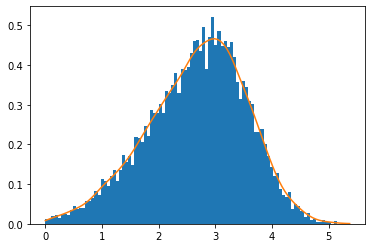

Histogram for F Test feature  1


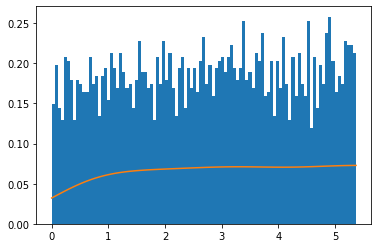

Histogram for F Test feature  2


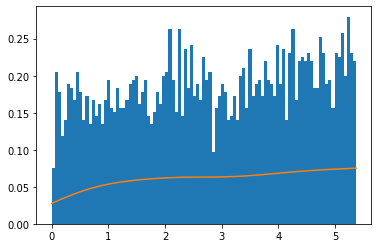

Histogram for F Test feature  3


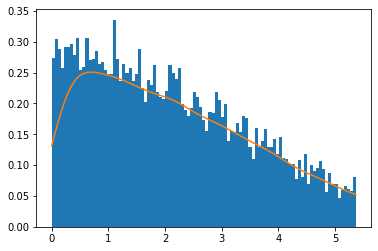

Histogram for F Test feature  4


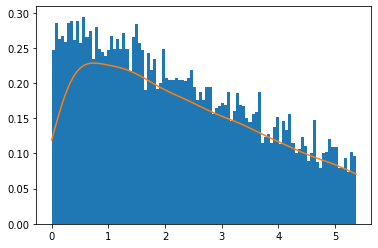

Histogram for F Test feature  5


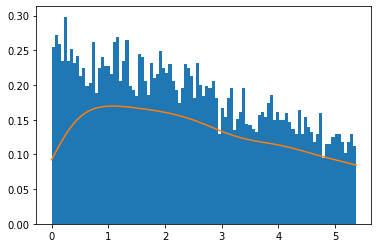

Histogram for F Test feature  6


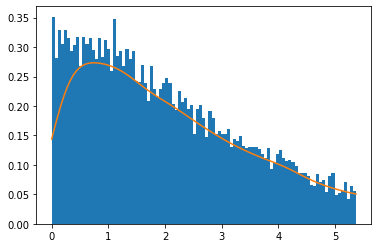

Histogram for F Test feature  7


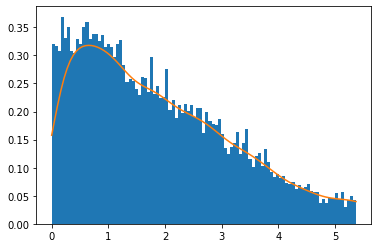

Histogram for F Test feature  8


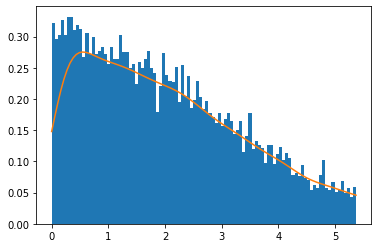

Histogram for F Test feature  9


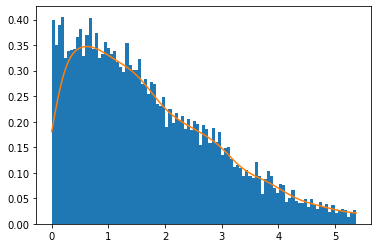

Histogram for F Test feature  10


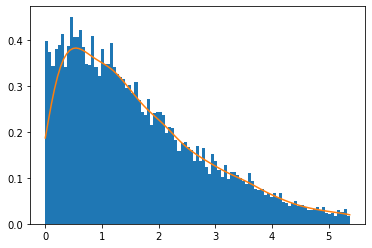

Histogram for F Test feature  11


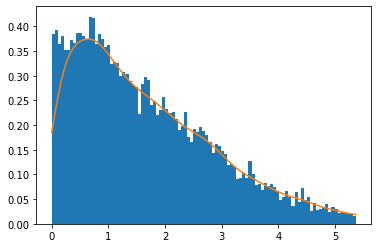

Histogram for F Test feature  12


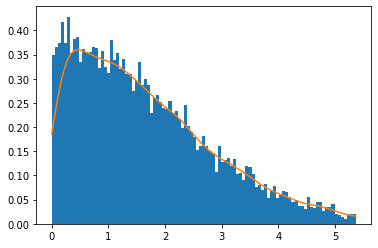

Histogram for F Test feature  13


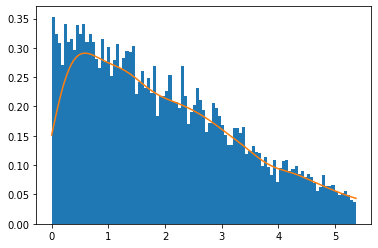

Histogram for F Test feature  14


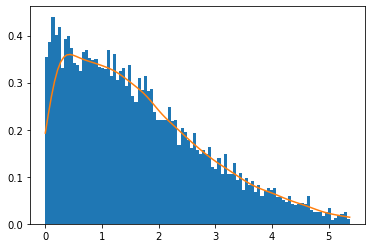

Histogram for F Test feature  15


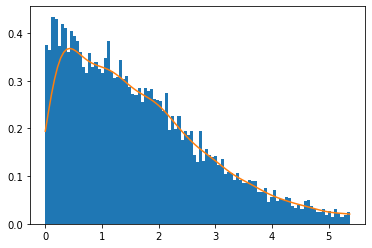

Histogram for F Test feature  16


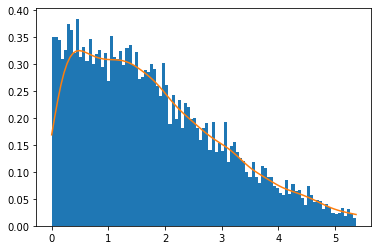

Histogram for F Test feature  17


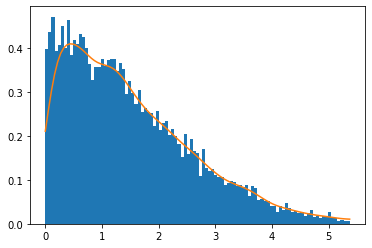

Histogram for F Test feature  18


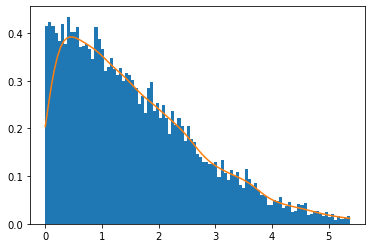

Histogram for F Test feature  19


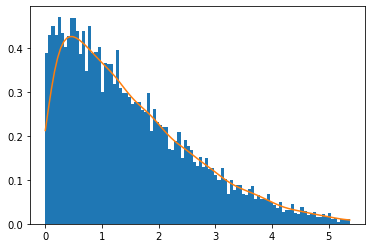

Histogram for F Test feature  20


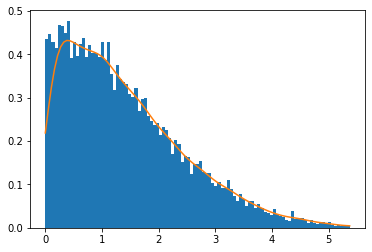

Histogram for F Test feature  21


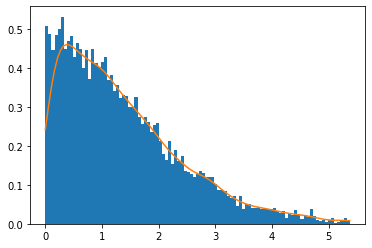

Histogram for F Test feature  22


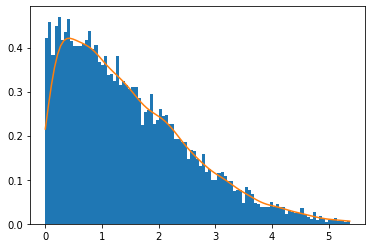

Histogram for F Test feature  23


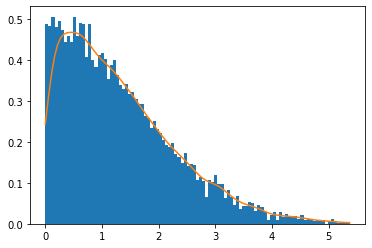

Histogram for F Test feature  24


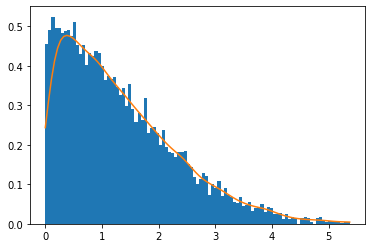

Histogram for F Test feature  25


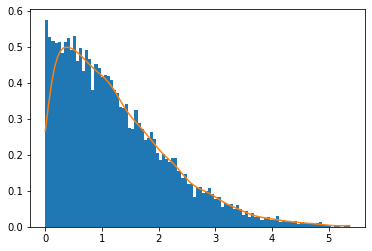

Histogram for F Test feature  26


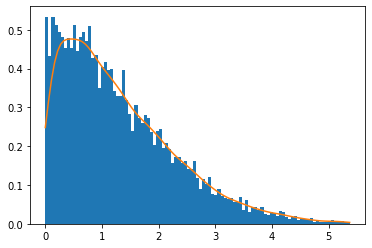

Histogram for F Test feature  27


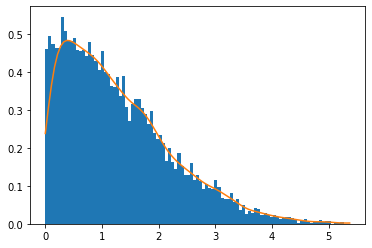

Histogram for F Test feature  28


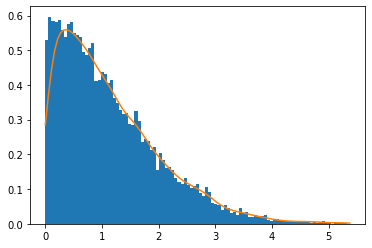

Histogram for F Test feature  29


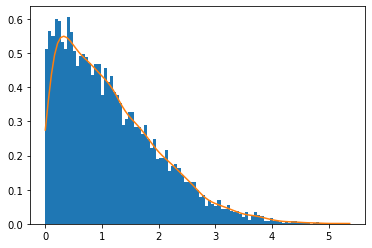

Histogram for F Test feature  30


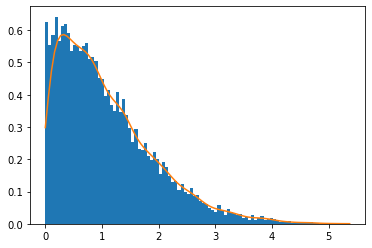

Histogram for F Test feature  31


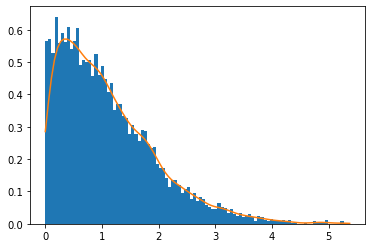

Histogram for F Test feature  32


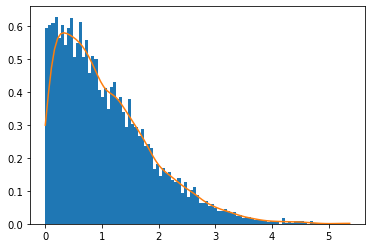

Histogram for F Test feature  33


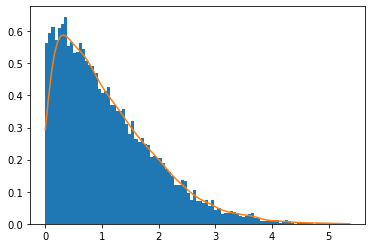

Histogram for F Test feature  34


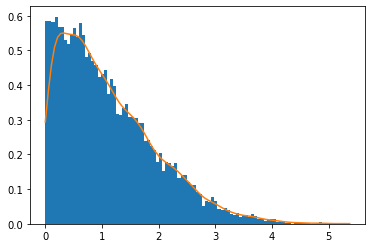

Histogram for F Test feature  35


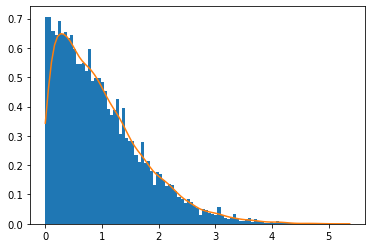

Histogram for F Test feature  36


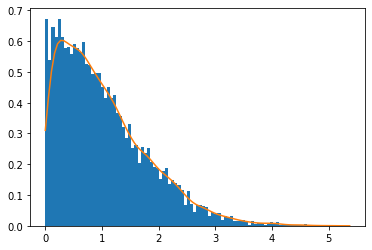

Histogram for F Test feature  37


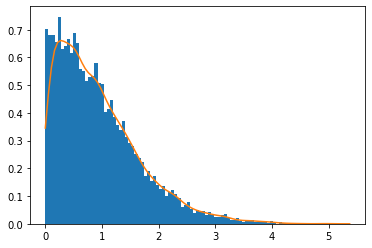

Histogram for F Test feature  38


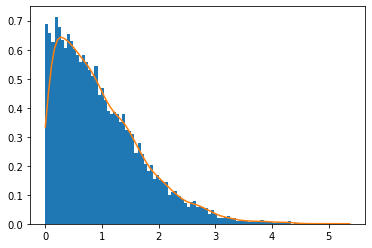

Histogram for F Test feature  39


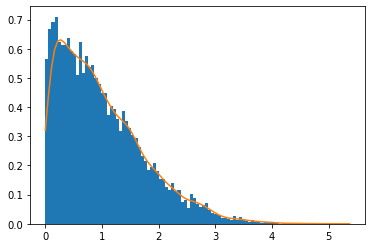

Histogram for F Test feature  40


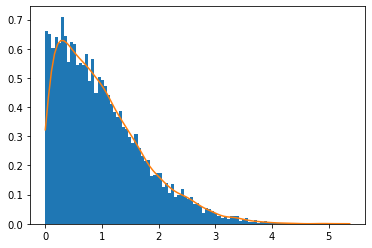

Histogram for F Test feature  41


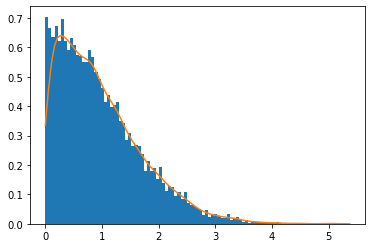

Histogram for F Test feature  42


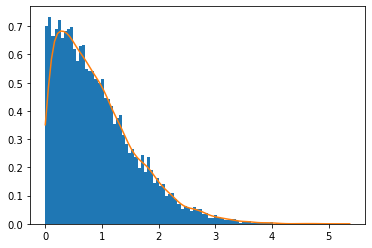

Histogram for F Test feature  43


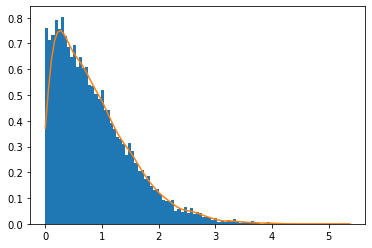

Histogram for F Test feature  44


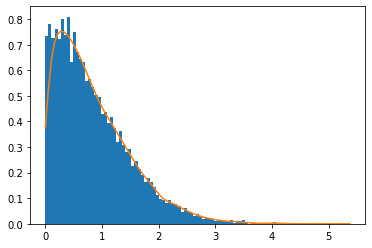

Histogram for F Test feature  45


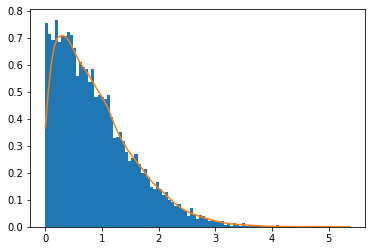

Histogram for F Test feature  46


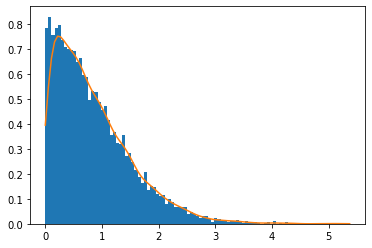

Histogram for F Test feature  47


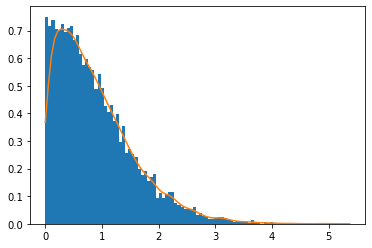

Histogram for F Test feature  48


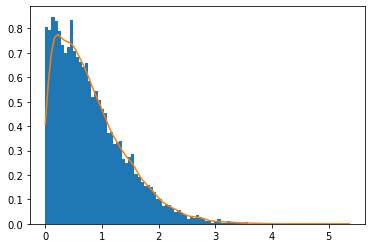

Histogram for F Test feature  49


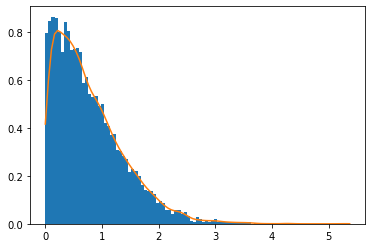

Histogram for F Test feature  50


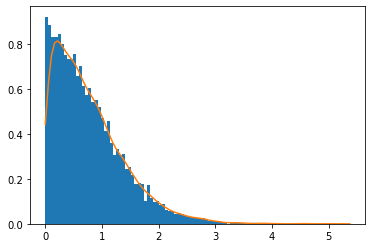

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.6078
LR Accuracy on test data - All features:  0.3425
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6069
Logistic Regression Accuracy on test data - rotated:  0.3407
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.609
Logistic Regression Accuracy on test data - rotated:  0.3485
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6074
Logistic Regression Accuracy on test data - rotated:  0.3103
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6029
Logistic Regression Accuracy on test data - rotated:  0.2667
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6055
Logistic Regression Accuracy on test data - rotated:  0.2753
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6021
Logistic Regression Accuracy on test data - rotated:  0.3182
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6055
Logistic Regression Accuracy on test data - rotated:  0.3192
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6081
Logistic Regression Accuracy on test data - rotated:  0.3219
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6049
Logistic Regression Accuracy on test data - rotated:  0.3396
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6047
Logistic Regression Accuracy on test data - rotated:  0.3425
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6033
Logistic Regression Accuracy on test data - rotated:  0.3183
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.3295
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6072
Logistic Regression Accuracy on test data - rotated:  0.3327
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6037
Logistic Regression Accuracy on test data - rotated:  0.3268
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6048
Logistic Regression Accuracy on test data - rotated:  0.3264
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6064
Logistic Regression Accuracy on test data - rotated:  0.3305
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3367
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6061
Logistic Regression Accuracy on test data - rotated:  0.3425
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6065
Logistic Regression Accuracy on test data - rotated:  0.3262
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6068
Logistic Regression Accuracy on test data - rotated:  0.3396
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6088
Logistic Regression Accuracy on test data - rotated:  0.342
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6037
Logistic Regression Accuracy on test data - rotated:  0.3536
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6044
Logistic Regression Accuracy on test data - rotated:  0.3431
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6049
Logistic Regression Accuracy on test data - rotated:  0.3325
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6077
Logistic Regression Accuracy on test data - rotated:  0.3348
Accuracy for without feature  25


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6079
Logistic Regression Accuracy on test data - rotated:  0.3438
Accuracy for without feature  26


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6029
Logistic Regression Accuracy on test data - rotated:  0.34
Accuracy for without feature  27


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6051
Logistic Regression Accuracy on test data - rotated:  0.3247
Accuracy for without feature  28


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.606
Logistic Regression Accuracy on test data - rotated:  0.3411
Accuracy for without feature  29


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.608
Logistic Regression Accuracy on test data - rotated:  0.327
Accuracy for without feature  30


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6075
Logistic Regression Accuracy on test data - rotated:  0.3454
Accuracy for without feature  31


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6046
Logistic Regression Accuracy on test data - rotated:  0.3451
Accuracy for without feature  32


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6044
Logistic Regression Accuracy on test data - rotated:  0.3438
Accuracy for without feature  33


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.607
Logistic Regression Accuracy on test data - rotated:  0.3494
Accuracy for without feature  34


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3475
Accuracy for without feature  35


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6085
Logistic Regression Accuracy on test data - rotated:  0.3438
Accuracy for without feature  36


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6068
Logistic Regression Accuracy on test data - rotated:  0.3392
Accuracy for without feature  37


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6045
Logistic Regression Accuracy on test data - rotated:  0.3437
Accuracy for without feature  38


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6083
Logistic Regression Accuracy on test data - rotated:  0.3408
Accuracy for without feature  39


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3364
Accuracy for without feature  40


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3433
Accuracy for without feature  41


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6089
Logistic Regression Accuracy on test data - rotated:  0.3446
Accuracy for without feature  42


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6066
Logistic Regression Accuracy on test data - rotated:  0.3398
Accuracy for without feature  43


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3436
Accuracy for without feature  44


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6061
Logistic Regression Accuracy on test data - rotated:  0.3351
Accuracy for without feature  45


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6053
Logistic Regression Accuracy on test data - rotated:  0.3407
Accuracy for without feature  46


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6069
Logistic Regression Accuracy on test data - rotated:  0.3455
Accuracy for without feature  47


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6062
Logistic Regression Accuracy on test data - rotated:  0.3427
Accuracy for without feature  48


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6084
Logistic Regression Accuracy on test data - rotated:  0.3427
Accuracy for without feature  49


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.606
Logistic Regression Accuracy on test data - rotated:  0.3409
Accuracy for without feature  50


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6077
Logistic Regression Accuracy on test data - rotated:  0.342




Results for lamda  1e-10

Printing eigenvalues
(512,)
[-2.62476508e+02 -4.28460872e+01 -2.10896682e+01 -2.02255692e+01
 -1.52736458e+01 -1.31379599e+01 -1.18247292e+01 -8.69321749e+00
 -7.92406683e+00 -6.75630704e+00 -6.26500871e+00 -5.48972051e+00
 -5.06486284e+00 -4.78603630e+00 -4.54236445e+00 -3.99211020e+00
 -3.32023545e+00 -3.28964189e+00 -2.81544248e+00 -2.79133072e+00
 -2.59646327e+00 -2.56769514e+00 -2.37251659e+00 -2.20216438e+00
 -2.10936769e+00 -2.06954752e+00 -1.98989587e+00 -1.81937916e+00
 -1.79129161e+00 -1.60287363e+00 -1.52224867e+00 -1.46626185e+00
 -1.40883055e+00 -1.29479196e+00 -1.25437700e+00 -1.22242817e+00
 -1.16348999e+00 -1.13114013e+00 -1.10228247e+00 -1.05075832e+00
 -1.01158058e+00 -9.57513041e-01 -9.54958838e-01 -9.00475021e-01
 -8.76855381e-01 -8.52956029e-01 -8.20284690e-01 -8.18694370e-01
 -7.80760188e-01 -7.43887523e

(512, 512)

array([[-4.57587233e-02,  3.01589273e-02, -1.83006134e-03, ...,
         6.23580959e-03, -1.51356283e-03,  5.30513660e-02],
       [-1.20317489e-01,  9.05112869e-02, -1.46577303e-01, ...,
         3.53589908e-04,  1.02885957e-03,  9.86060432e-03],
       [-7.77640973e-02,  8.66546671e-02, -8.54795226e-02, ...,
         3.07383569e-03,  5.75799699e-04, -2.56525487e-02],
       ...,
       [-2.56508024e-02, -2.58860927e-02,  9.15262163e-03, ...,
         1.91754141e-03, -1.01901101e-03,  7.37840130e-03],
       [-1.62598013e-02, -2.91367256e-02,  2.20533033e-02, ...,
         1.15201514e-02,  8.40321895e-05, -4.95922806e-02],
       [-6.24212317e-03, -6.90415581e-03,  1.26695095e-02, ...,
        -1.22231287e-02, -1.59967748e-02,  1.84949439e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[-262.4765078   -42.84608716  -21.08966824  -20.22556919  -15.27364584
  -13.13795988  -11.82472919   -8.69321749   -7.92406683   -6.75630704
   -6.26500871   -5.48972051   -5.06486284   -4.7860363    -4.54236445
   -3.9921102    -3.32023545   -3.28964189   -2.81544248   -2.79133072
   -2.59646327   -2.56769514   -2.37251659   -2.20216438   -2.10936769
   -2.06954752   -1.98989587   -1.81937916   -1.79129161   -1.60287363
   -1.52224867   -1.46626185   -1.40883055   -1.29479196   -1.254377
   -1.22242817   -1.16348999   -1.13114013   -1.10228247   -1.05075832
   -1.01158058   -0.95751304   -0.95495884   -0.90047502   -0.87685538
   -0.85295603   -0.82028469   -0.81869437   -0.78076019   -0.74388752
   -0.7302301 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-262.4765078   -42.84608716  -21.08966824  -20.22556919  -15.27364584
  -13.13795988  -11.82472919   -8.69321749   -7.92406683   -6.75630704
   

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,3.014026,10.958404,7.811707,2.135623,5.344534,3.837822,2.157873,1.819622,2.122562,3.388704,...,1.832715,1.769671,0.145154,1.644518,0.227694,0.419990,0.484579,0.743512,0.311083,0.228092
1,2.435494,5.434237,3.312205,2.896664,5.298763,3.661126,7.180145,5.005631,8.484661,2.218565,...,1.633036,2.559192,0.721149,0.097032,0.587422,1.397041,0.879168,0.141029,0.384657,0.557820
2,3.148465,4.924857,2.637485,7.901717,6.745502,8.399560,6.856125,6.629743,0.878836,0.535822,...,0.532107,0.438697,0.597196,1.805102,0.173973,1.346269,0.060406,0.960051,0.754895,0.037127
3,3.554349,12.265631,10.924899,1.466506,5.934013,4.459330,4.600330,2.461922,3.589450,2.868313,...,1.179656,0.405528,1.060293,0.945780,0.214628,0.547605,1.223901,1.250912,0.369357,0.319336
4,2.496241,7.508074,4.024816,3.059796,2.488974,3.909034,2.131783,0.546363,0.197823,0.066432,...,1.157188,1.707071,0.057096,0.244246,0.310760,0.146719,0.484034,1.045322,0.885784,1.050282


Histogram for F Test feature  0


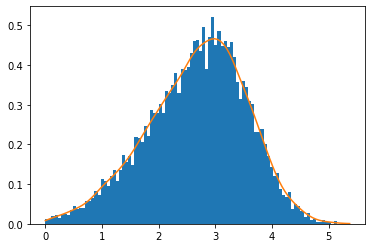

Histogram for F Test feature  1


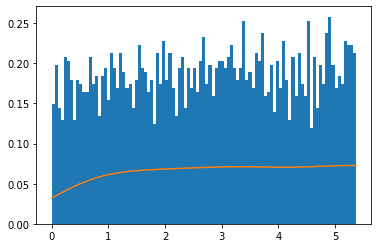

Histogram for F Test feature  2


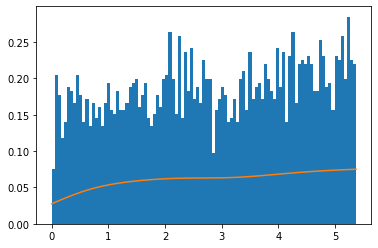

Histogram for F Test feature  3


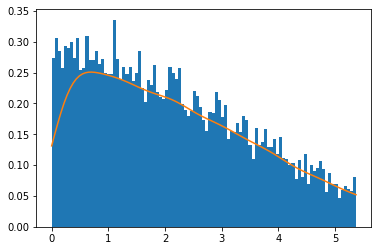

Histogram for F Test feature  4


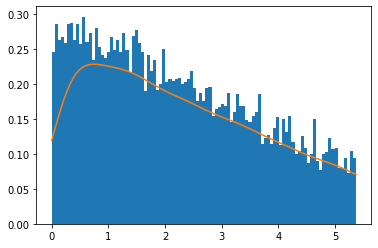

Histogram for F Test feature  5


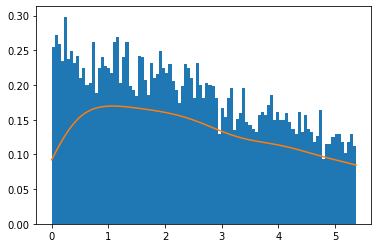

Histogram for F Test feature  6


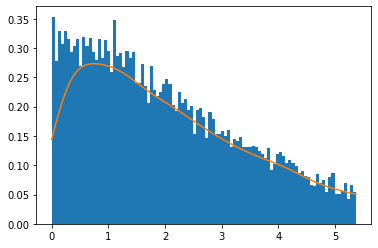

Histogram for F Test feature  7


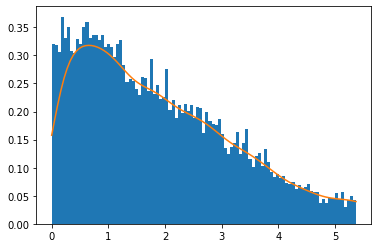

Histogram for F Test feature  8


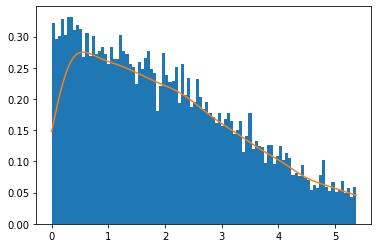

Histogram for F Test feature  9


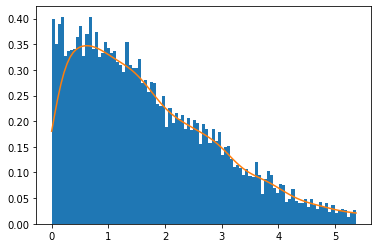

Histogram for F Test feature  10


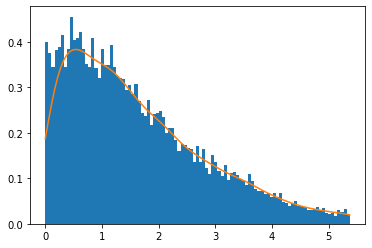

Histogram for F Test feature  11


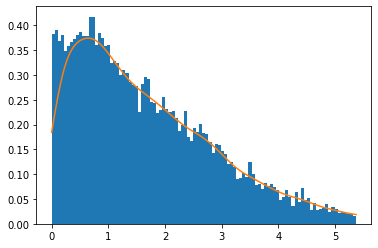

Histogram for F Test feature  12


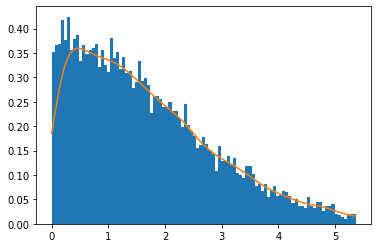

Histogram for F Test feature  13


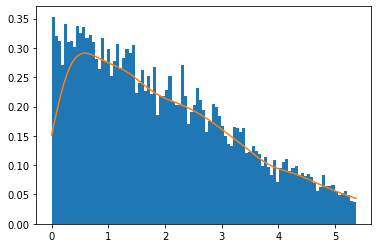

Histogram for F Test feature  14


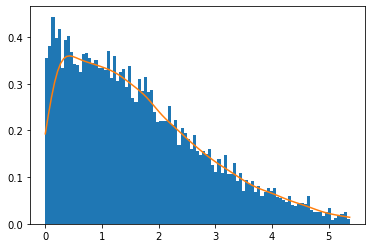

Histogram for F Test feature  15


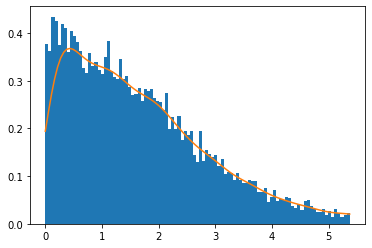

Histogram for F Test feature  16


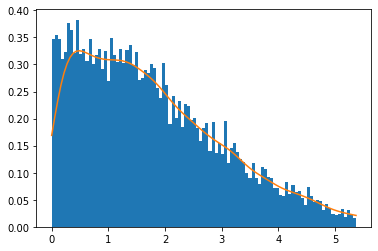

Histogram for F Test feature  17


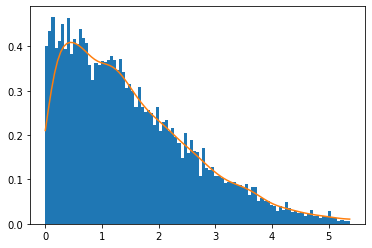

Histogram for F Test feature  18


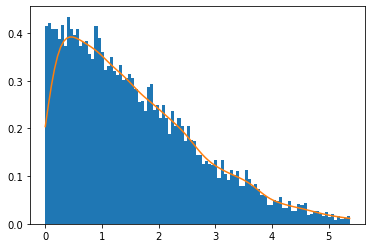

Histogram for F Test feature  19


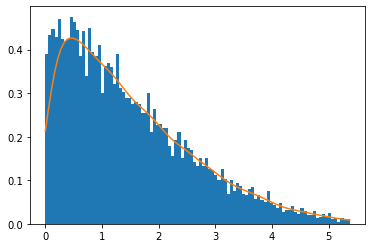

Histogram for F Test feature  20


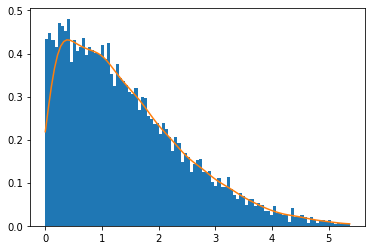

Histogram for F Test feature  21


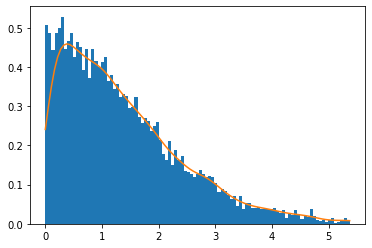

Histogram for F Test feature  22


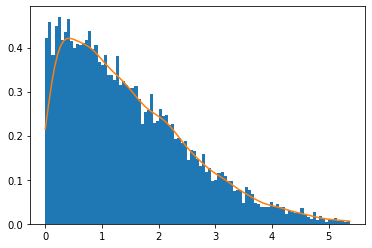

Histogram for F Test feature  23


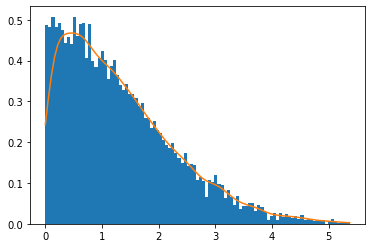

Histogram for F Test feature  24


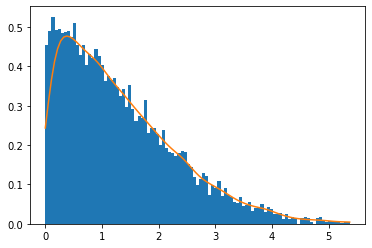

Histogram for F Test feature  25


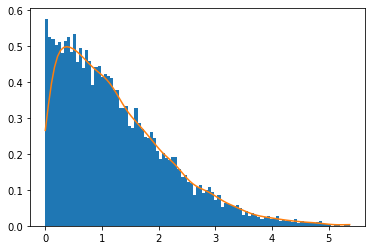

Histogram for F Test feature  26


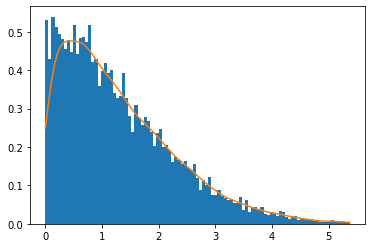

Histogram for F Test feature  27


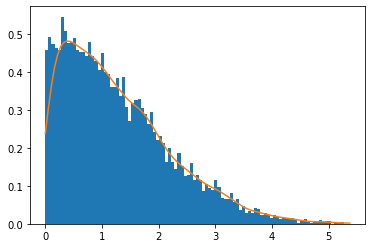

Histogram for F Test feature  28


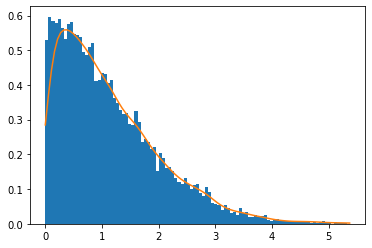

Histogram for F Test feature  29


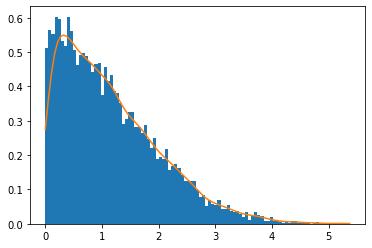

Histogram for F Test feature  30


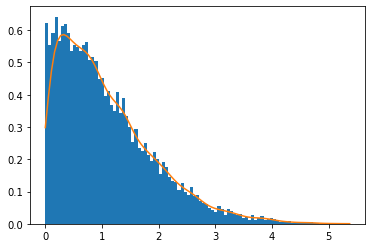

Histogram for F Test feature  31


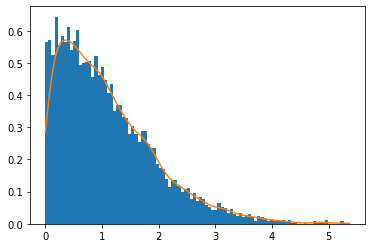

Histogram for F Test feature  32


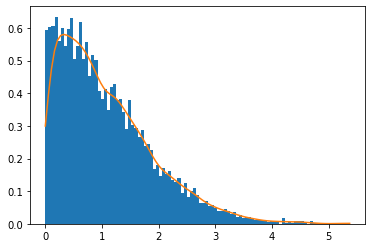

Histogram for F Test feature  33


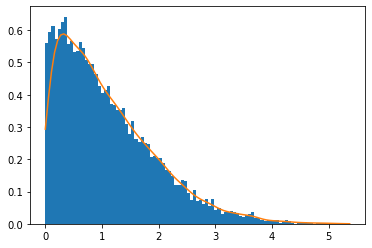

Histogram for F Test feature  34


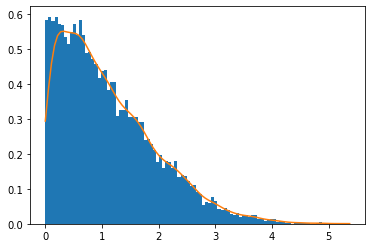

Histogram for F Test feature  35


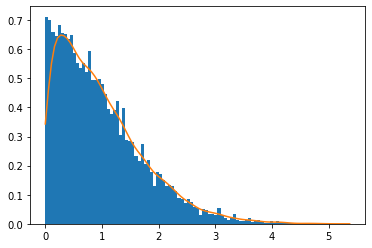

Histogram for F Test feature  36


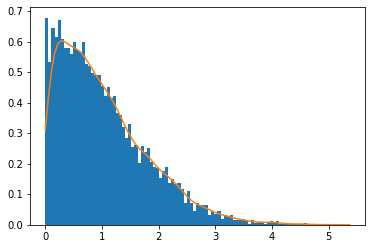

Histogram for F Test feature  37


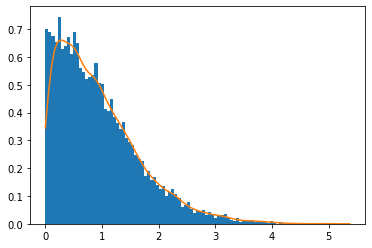

Histogram for F Test feature  38


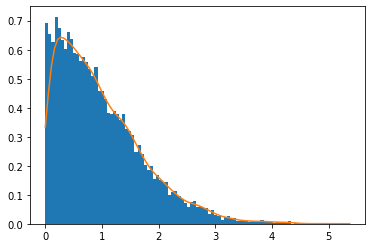

Histogram for F Test feature  39


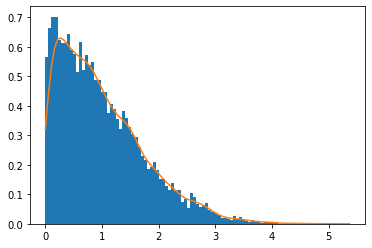

Histogram for F Test feature  40


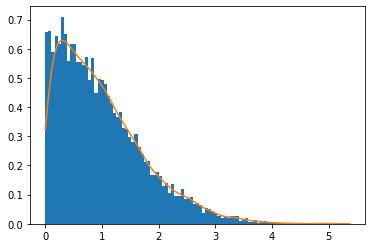

Histogram for F Test feature  41


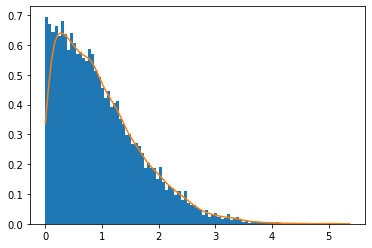

Histogram for F Test feature  42


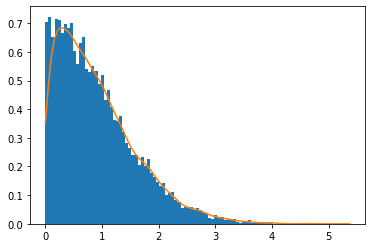

Histogram for F Test feature  43


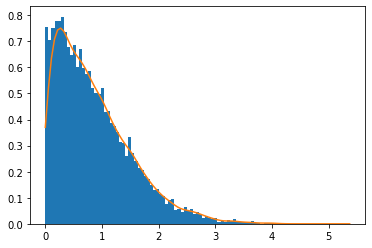

Histogram for F Test feature  44


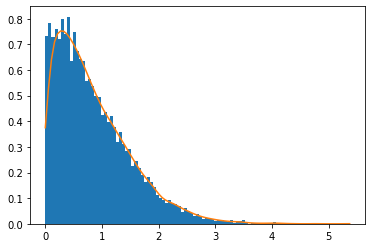

Histogram for F Test feature  45


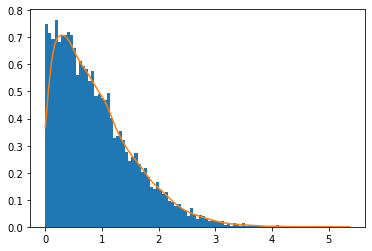

Histogram for F Test feature  46


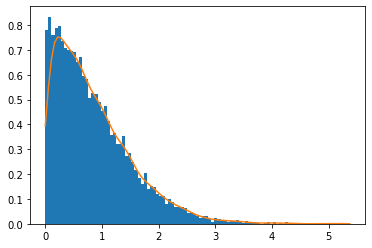

Histogram for F Test feature  47


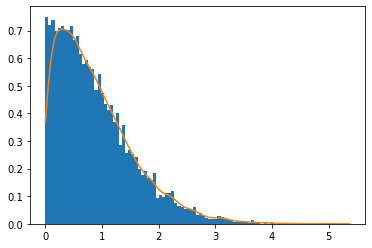

Histogram for F Test feature  48


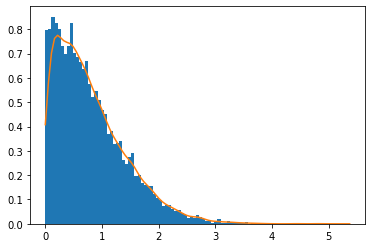

Histogram for F Test feature  49


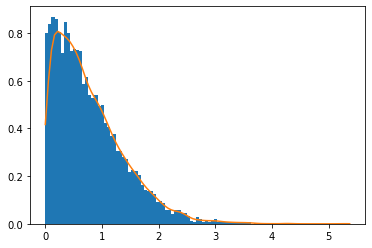

Histogram for F Test feature  50


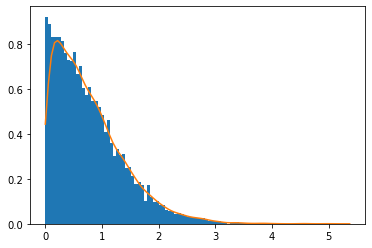

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.6077
LR Accuracy on test data - All features:  0.3423
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6064
Logistic Regression Accuracy on test data - rotated:  0.3402
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6093
Logistic Regression Accuracy on test data - rotated:  0.3487
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6081
Logistic Regression Accuracy on test data - rotated:  0.3105
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6029
Logistic Regression Accuracy on test data - rotated:  0.2664
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6054
Logistic Regression Accuracy on test data - rotated:  0.2748
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6019
Logistic Regression Accuracy on test data - rotated:  0.3191
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6053
Logistic Regression Accuracy on test data - rotated:  0.3193
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6075
Logistic Regression Accuracy on test data - rotated:  0.3226
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6059
Logistic Regression Accuracy on test data - rotated:  0.3394
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6041
Logistic Regression Accuracy on test data - rotated:  0.3425
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6036
Logistic Regression Accuracy on test data - rotated:  0.3187
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6067
Logistic Regression Accuracy on test data - rotated:  0.3293
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6072
Logistic Regression Accuracy on test data - rotated:  0.332
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.603
Logistic Regression Accuracy on test data - rotated:  0.3268
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6047
Logistic Regression Accuracy on test data - rotated:  0.326
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6064
Logistic Regression Accuracy on test data - rotated:  0.3307
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6066
Logistic Regression Accuracy on test data - rotated:  0.3373
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.606
Logistic Regression Accuracy on test data - rotated:  0.3418
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6066
Logistic Regression Accuracy on test data - rotated:  0.325
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6068
Logistic Regression Accuracy on test data - rotated:  0.3385
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6089
Logistic Regression Accuracy on test data - rotated:  0.3426
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6038
Logistic Regression Accuracy on test data - rotated:  0.3521
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6049
Logistic Regression Accuracy on test data - rotated:  0.3428
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6057
Logistic Regression Accuracy on test data - rotated:  0.3341
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6074
Logistic Regression Accuracy on test data - rotated:  0.3349
Accuracy for without feature  25


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6078
Logistic Regression Accuracy on test data - rotated:  0.3438
Accuracy for without feature  26


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6032
Logistic Regression Accuracy on test data - rotated:  0.3405
Accuracy for without feature  27


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6041
Logistic Regression Accuracy on test data - rotated:  0.3245
Accuracy for without feature  28


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6066
Logistic Regression Accuracy on test data - rotated:  0.3408
Accuracy for without feature  29


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6076
Logistic Regression Accuracy on test data - rotated:  0.3281
Accuracy for without feature  30


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6074
Logistic Regression Accuracy on test data - rotated:  0.3457
Accuracy for without feature  31


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6037
Logistic Regression Accuracy on test data - rotated:  0.3455
Accuracy for without feature  32


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6047
Logistic Regression Accuracy on test data - rotated:  0.3436
Accuracy for without feature  33


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3498
Accuracy for without feature  34


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6069
Logistic Regression Accuracy on test data - rotated:  0.3467
Accuracy for without feature  35


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.608
Logistic Regression Accuracy on test data - rotated:  0.3439
Accuracy for without feature  36


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6074
Logistic Regression Accuracy on test data - rotated:  0.3393
Accuracy for without feature  37


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6051
Logistic Regression Accuracy on test data - rotated:  0.3441
Accuracy for without feature  38


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6086
Logistic Regression Accuracy on test data - rotated:  0.3407
Accuracy for without feature  39


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3362
Accuracy for without feature  40


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6052
Logistic Regression Accuracy on test data - rotated:  0.3435
Accuracy for without feature  41


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6079
Logistic Regression Accuracy on test data - rotated:  0.3444
Accuracy for without feature  42


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6065
Logistic Regression Accuracy on test data - rotated:  0.3398
Accuracy for without feature  43


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6073
Logistic Regression Accuracy on test data - rotated:  0.3431
Accuracy for without feature  44


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6067
Logistic Regression Accuracy on test data - rotated:  0.334
Accuracy for without feature  45


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.605
Logistic Regression Accuracy on test data - rotated:  0.3405
Accuracy for without feature  46


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6071
Logistic Regression Accuracy on test data - rotated:  0.3455
Accuracy for without feature  47


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6059
Logistic Regression Accuracy on test data - rotated:  0.3424
Accuracy for without feature  48


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6086
Logistic Regression Accuracy on test data - rotated:  0.3427
Accuracy for without feature  49


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.6065
Logistic Regression Accuracy on test data - rotated:  0.3408
Accuracy for without feature  50
Logistic Regression Accuracy within training data - not rotated:  0.6077
Logistic Regression Accuracy on test data - rotated:  0.3412


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [100000,0.1,0.01,0.001,0.0001,0.0000000001]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.1) # % of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(train_rotation_labels)/2),:] - Z[int(len(train_rotation_labels)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = rotation_coefficients @ rotation_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    print("Printing eigenvalues")
    print(eigenvalues.shape)
    print(eigenvalues)
    print("Printing eigenvectors")
    display(eigenvectors.shape)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = rotation_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_rotated = torch.from_numpy(np.linalg.lstsq(L, Z_test_rotated.transpose(), rcond=None)[0].transpose())



    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_rotated.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Trained on original images, tested on rotated images: all Features in F_test
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    X_torch_train = F_test_original
    X_torch_test = F_test_rotated
    X_torch_test_within = F_test_original

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)


    logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train.detach().numpy(), targets_train)

    print('LR Accuracy within training data - All features : ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_test_within))
    print('LR Accuracy on test data - All features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_test))

    
    


    # Trained on original images, tested on rotated images: Rotation Features removed from F_test

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)

    for i in range(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_test_original.detach().numpy().copy()
        X_torch_test = F_test_rotated.detach().numpy().copy()
        X_torch_test_within = F_test_original.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train, targets_train)

        print('Logistic Regression Accuracy within training data - not rotated: ',logistic_regression_model.score(X_torch_test_within, targets_test_within))
        print('Logistic Regression Accuracy on test data - rotated: ', logistic_regression_model.score(X_torch_test, targets_test))




